In [1]:
import skysurvey
import numpy as np
import sncosmo
from scipy.ndimage import gaussian_filter
from scipy.spatial import cKDTree
import corner
import pandas
from code import *
from tqdm.notebook import tqdm
import time

In [2]:
import warnings
from iminuit.warnings import IMinuitWarning
warnings.filterwarnings('ignore', category=IMinuitWarning) 

# skysurvey tests

In [12]:
snia = skysurvey.SNeIa()

In [13]:
data = snia.draw(size=10_000, inplace=True)

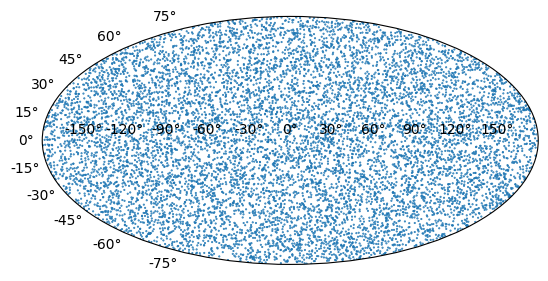

In [14]:
fig = plt.figure()
ax = fig.add_subplot(projection="mollweide")
ax.scatter(
    (snia.data["ra"] - 360 * (snia.data["ra"] > 180)) * np.pi / 180,
    snia.data["dec"] * np.pi / 180,
    linestyle="",
    marker=".",
    s=1,
)

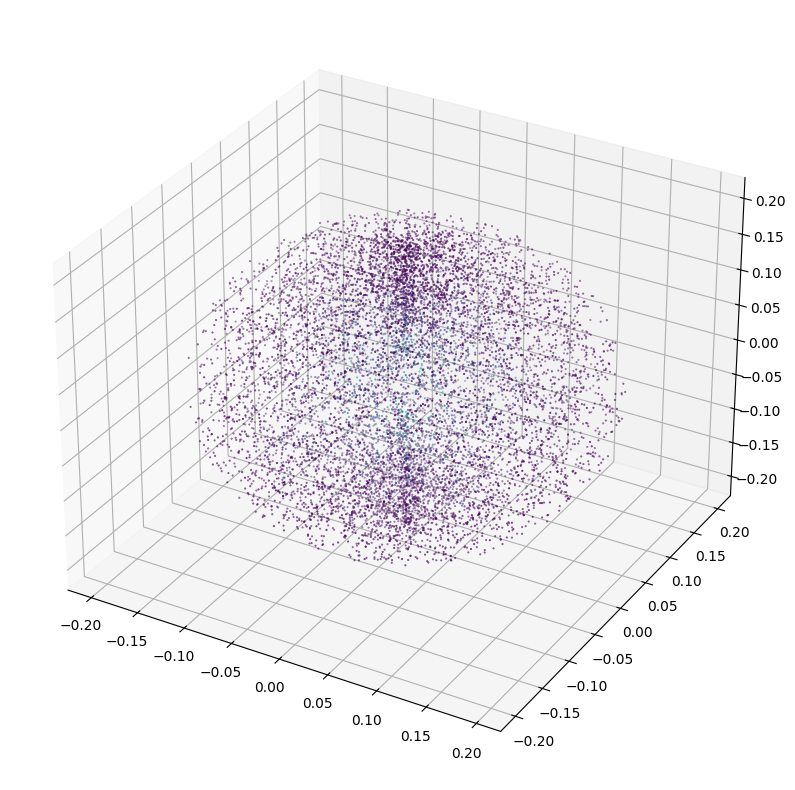

In [15]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection="3d"))

count, bin = np.histogramdd([snia.data["ra"], snia.data["dec"], snia.data["z"]], bins=50)
count = gaussian_filter(count, 0.9)
binra, bindec, binz = bin
x, y, z = np.meshgrid(
    (binra[:-1] + binra[1:]) / 2 - binra.min(),
    (bindec[:-1] + bindec[1:]) / 2 - bindec.min(),
    (binz[:-1] + binz[1:]) / 2 - binz.min(),
)
tree = cKDTree(np.dstack((x.flatten(), y.flatten(), z.flatten())).reshape(-1, 3))
pts = np.vstack(
    [snia.data["ra"] - binra.min(), snia.data["dec"] - bindec.min(), snia.data["z"] - binz.min()]
).T


def density_tree(
    pts: np.ndarray, tree: cKDTree, density: np.ndarray, k=1
) -> np.ndarray:
    dist_id, nn_id = tree.query(pts, k=k)
    try:
        density = np.average(density[nn_id], axis=1, weights=1 / dist_id)
    except np.AxisError:
        density = density[nn_id]
    return density


c = density_tree(
    pts, tree, np.transpose(count, axes=[1, 0, 2]).flatten()[::-1], k=1
)

ax.scatter(
    np.cos(snia.data["ra"]) * np.sin(snia.data["dec"]) * snia.data["z"],
    np.sin(snia.data["ra"]) * np.sin(snia.data["dec"]) * snia.data["z"],
    np.cos(snia.data["dec"]) * snia.data["z"],
    s=1,
    c=c,
    marker=".",
)

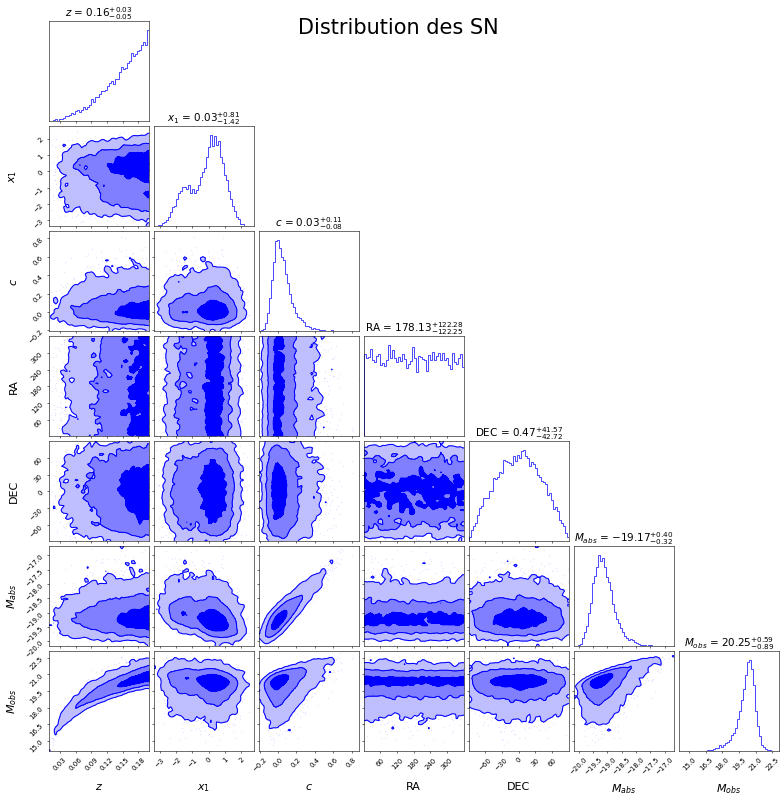

In [17]:
fig = corner_(
    snia.data,
    var_names=["z", "x1", "c", "ra", "dec", "magabs", "magobs"],
    labels=[r"$z$", r"$x_1$", r"$c$", r"RA", r"DEC", r"$M_{abs}$", r"$M_{obs}$"],
    title='Distribution des SN',
)

In [18]:
# footprint
from shapely import geometry

footprint = geometry.Point(0, 0).buffer(2)

# observing logs
from skysurvey.tools import utils

size = 10_000

data = {}
data["gain"] = 1
data["zp"] = 30
data["skynoise"] = np.random.normal(size=size, loc=200, scale=20)
data["mjd"] = np.random.uniform(56_000, 56_200, size=size)
data["band"] = np.random.choice(["ztfg", "ztfr", "ztfi"], size=size)

data["ra"], data["dec"] = utils.random_radec(
    size=size, ra_range=[200, 250], dec_range=[-20, 10]
)

# Load a GridSurvey
survey = skysurvey.Survey.from_pointings(data, footprint=footprint)

In [25]:
import pickle

with open('../data/ztf_survey.pkl','rb') as file:
    survey = pickle.load(file)

In [40]:
dset = skysurvey.DataSet.from_targets_and_survey(snia, survey)

/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ztffields/projection.py:151: UserWarning: you don't have dask-geopandas, you have more than 20_000 fields, this would be faster with dask-greopandas
  warnings.warn("you don't have dask-geopandas, you have more than 20_000 fields, this would be faster with dask-greopandas")
/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/skysurvey/dataset.py:154: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences
  data = pandas.concat(lightcurves, keys=fieldids # store fieldid


In [128]:
dataset = dset.get_ndetection() > 5
detected = dataset[dataset].index

In [130]:
len(detected)

360

Text(0.5, 0.98, 'Distribution des SN détectées')

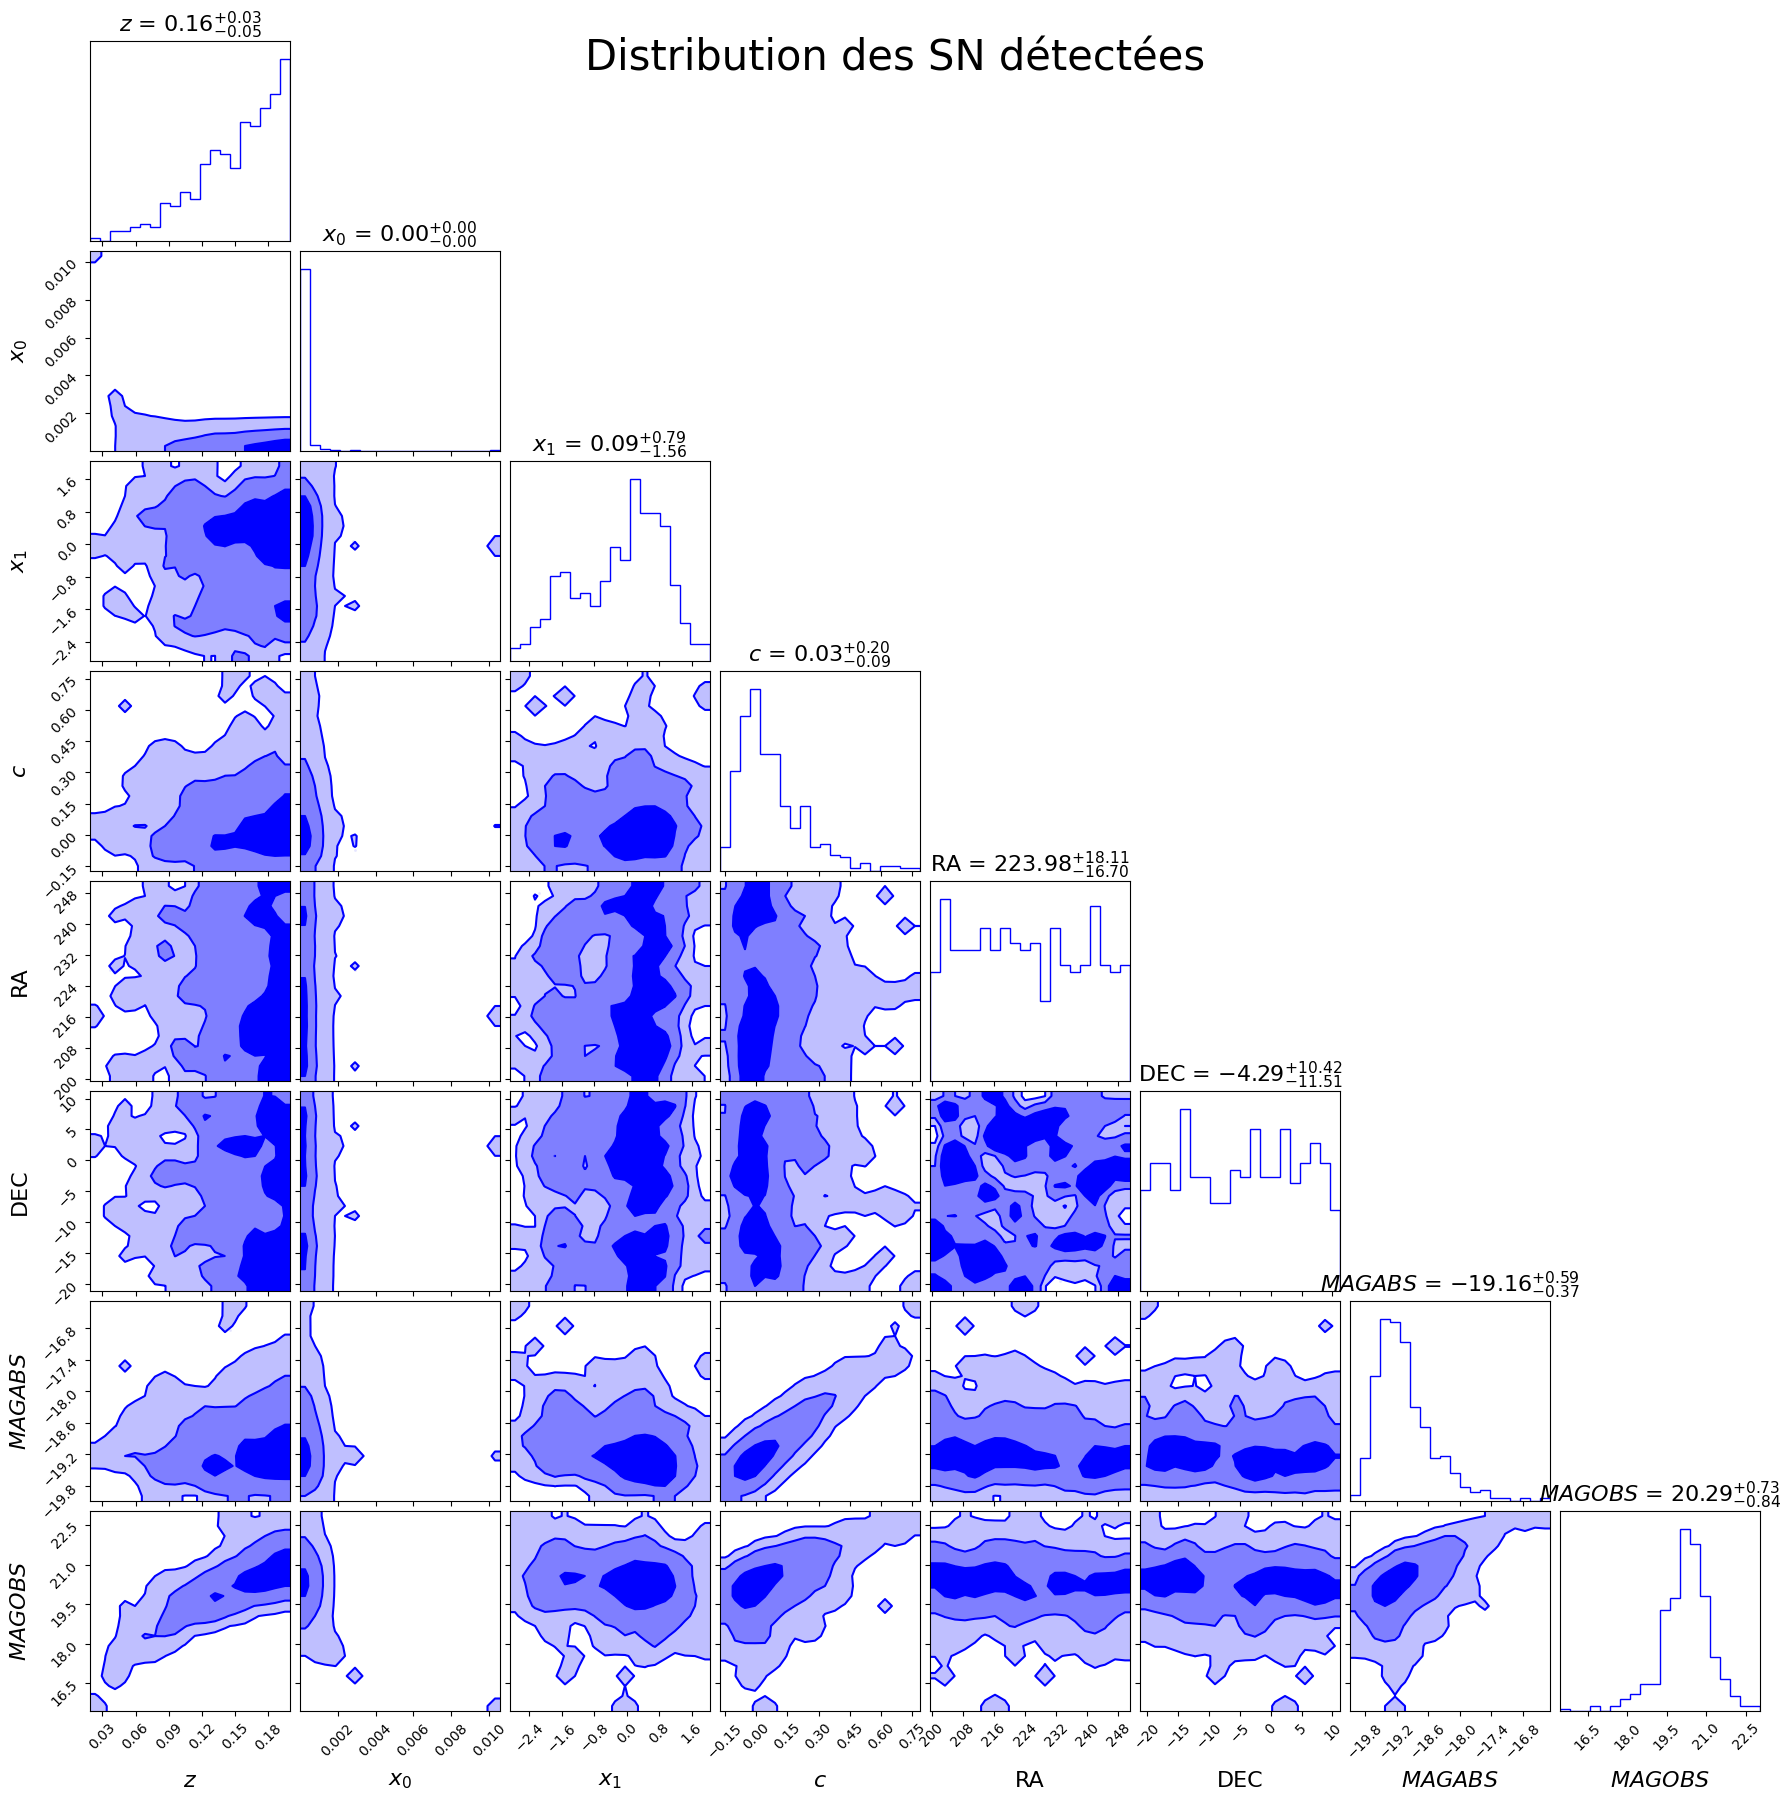

In [81]:
fig = corner.corner(
    dset.targets.data.loc[detected],
    var_names=["z", "x0", "x1", "c", "ra", "dec", "magabs", "magobs"],
    show_titles=True,
    bins=20,
    smooth=0.9,
    quantiles=None,
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=16),
    color="b",
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.0)),
    plot_density=False,
    plot_datapoints=True,
    fill_contours=True,
    max_n_ticks=7,
    hist_kwargs=dict(density=True, color="b"),
    labels=[
        r"$z$",
        r"$x_0$",
        r"$x_1$",
        r"$c$",
        r"RA",
        r"DEC",
        r"$MAGABS$",
        r"$MAGOBS$",
    ],
    alpha=0.2,
)
fig.suptitle('Distribution des SN détectées', fontsize=30)

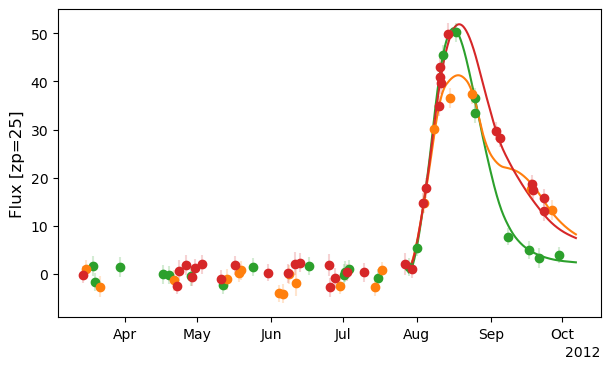

In [18]:
_ = dset.show_target_lightcurve(index=detected[212])

In [85]:
fixed = {"z": dset.targets.data.loc[detected]["z"]}

guess = {
    "t0": dset.targets.data.loc[detected]["t0"],
    "c": dset.targets.data.loc[detected]["c"],
    "x0": dset.targets.data.loc[detected]["x0"],
    "x1": dset.targets.data.loc[detected]["x1"],
}
bounds = {
    "t0": dset.targets.data.loc[detected]["t0"].apply(lambda x: [x-5, x+5]),
    "c": dset.targets.data.loc[detected]["c"].apply(lambda x: [-0.3, 1.0]),
    "x0": dset.targets.data.loc[detected]["x0"].apply(lambda x: [0, 0.1]),
    "x1": dset.targets.data.loc[detected]["x1"].apply(lambda x: [-4, 4]),
}

results, meta = dset.fit_lightcurves(
    source=sncosmo.Model("salt2"),
    index=detected,
    use_dask=False,
    fixedparams=fixed,
    guessparams=guess,
    bounds=bounds,
)

In [87]:
results

value     error        cov_t0        cov_x0        cov_x1  \
index                                                                        
61    z       0.165950       NaN           NaN           NaN           NaN   
      t0  56076.642355  0.000119  1.406037e-08 -8.320405e-15  3.406144e-10   
      x0      0.000141  0.000003 -8.320405e-15  8.518550e-12 -1.609167e-07   
      x1     -1.494876  0.173515  3.406144e-10 -1.609167e-07  3.012934e-02   
      c      -0.100651  0.016845  5.986491e-11 -4.064239e-08  7.499385e-04   
...                ...       ...           ...           ...           ...   
9976  z       0.175650       NaN           NaN           NaN           NaN   
      t0  56040.948513  0.020004  4.001741e-04  2.702059e-13 -1.271361e-08   
      x0      0.000044  0.000002  2.702059e-13  3.919417e-12 -2.269164e-07   
      x1     -0.518954  0.285869 -1.271361e-08 -2.269164e-07  8.186272e-02   
      c       0.366539  0.031626 -4.540617e-09 -5.675693e-08  2.304500e-03   

                 cov_c         truth  
index                                 
61    z            NaN       0.16595  
      t0  5.986491e-11  56075.347656  
      x0 -4.064239e-08       0.00014  
      x1  7.499385e-04         -1.77  
      c   2.838648e-04     -0.111124  
...                ...           ...  
9976  z            NaN       0.17565  
      t0 -4.540617e-09  56040.851562  
      x0 -5.675693e-08      0.000045  
      x1  2.304500e-03        -0.195  
      c   1.001014e-03      0.343443  

[1800 rows x 7 columns]

In [88]:
better_results = pandas.DataFrame(
    {
        col: np.array(results["value"].loc[map(lambda x: (x, col), detected)]-results["truth"].loc[map(lambda x: (x, col), detected)])
        for col in guess.keys()
    }
)

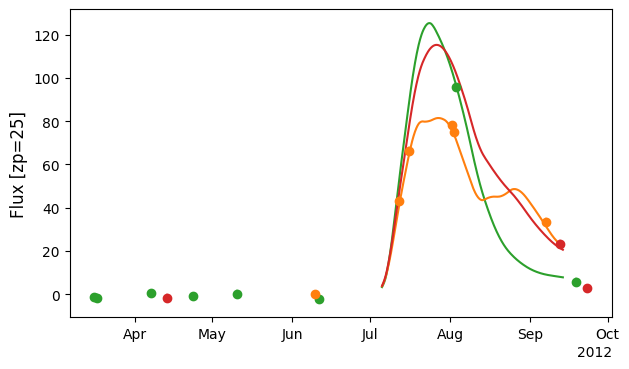

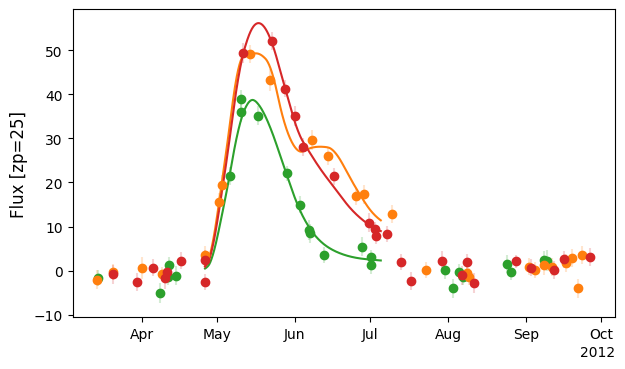

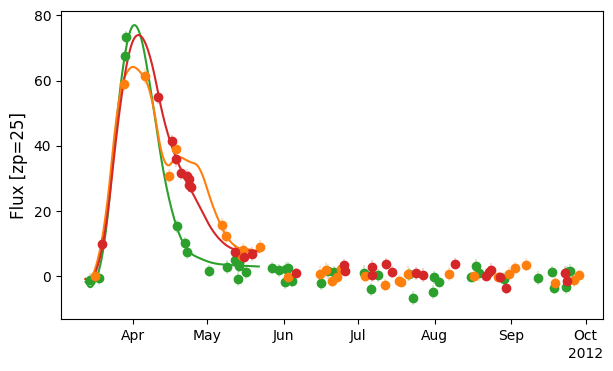

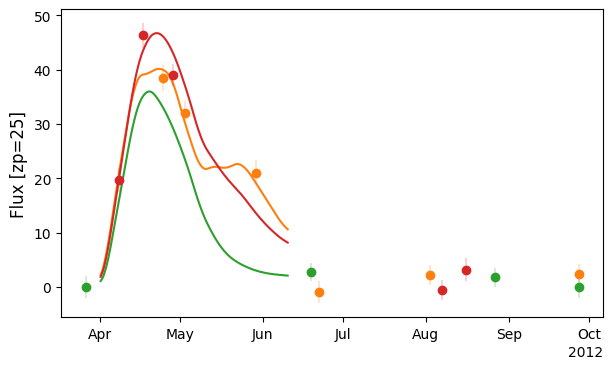

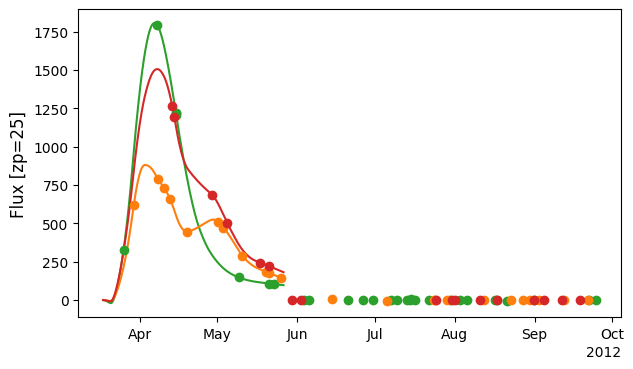

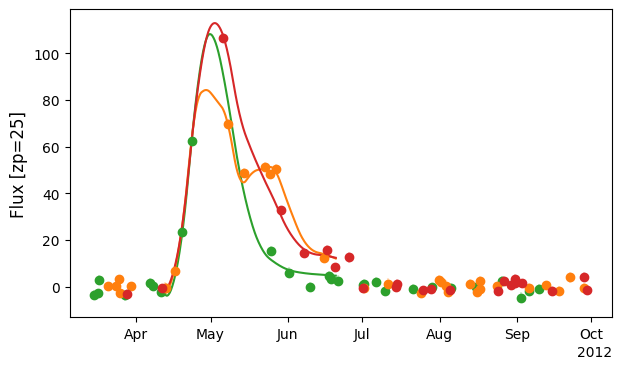

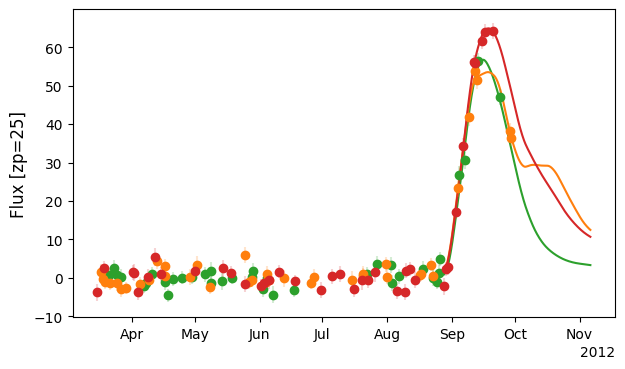

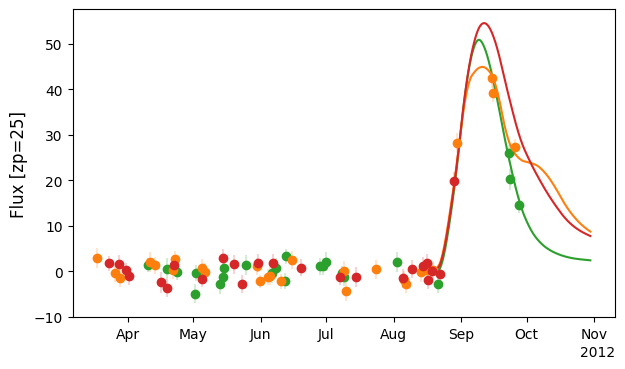

In [89]:
_ = dset.show_target_lightcurve(index=detected[better_results[better_results["t0"]==better_results['t0'].max()].index[0]])
_ = dset.show_target_lightcurve(index=detected[better_results[better_results["t0"]==better_results['t0'].min()].index[0]])

_ = dset.show_target_lightcurve(index=detected[better_results[better_results["c"]==better_results['c'].min()].index[0]])
_ = dset.show_target_lightcurve(index=detected[better_results[better_results["c"]==better_results['c'].max()].index[0]])

_ = dset.show_target_lightcurve(index=detected[better_results[better_results["x0"]==better_results['x0'].min()].index[0]])
_ = dset.show_target_lightcurve(index=detected[better_results[better_results["x0"]==better_results['x0'].max()].index[0]])

_ = dset.show_target_lightcurve(index=detected[better_results[better_results["x1"]==better_results['x1'].min()].index[0]])
_ = dset.show_target_lightcurve(index=detected[better_results[better_results["x1"]==better_results['x1'].max()].index[0]])

Text(0.5, 0.98, 'Erreur absolue sur les paramètres reconstruits')

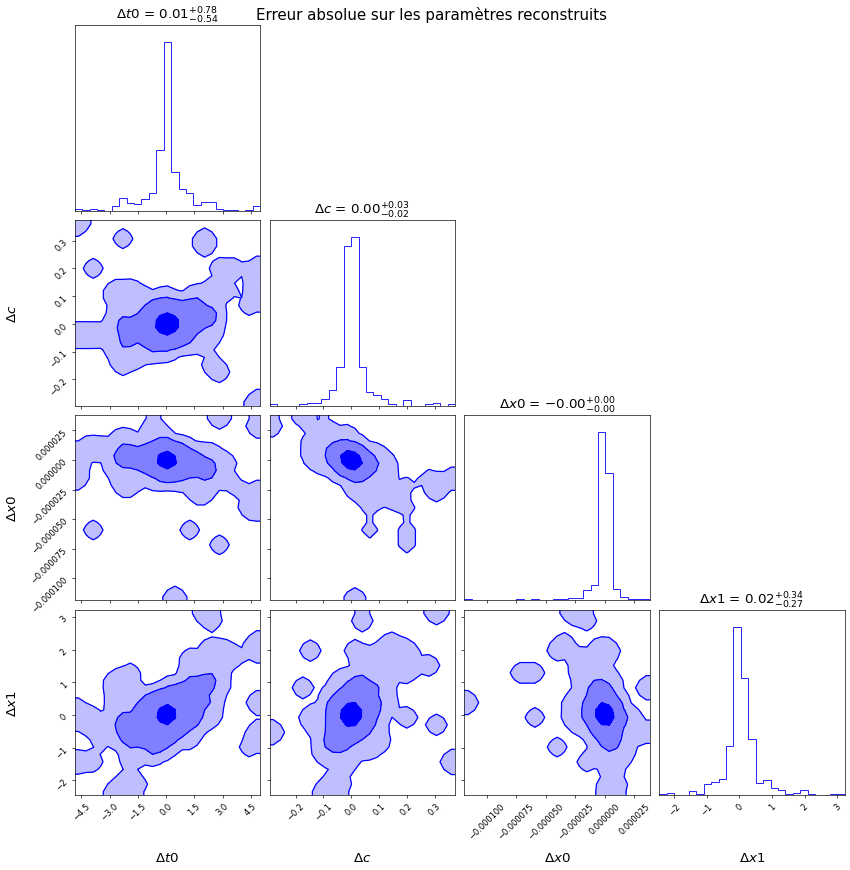

In [158]:
fig = plt.figure(figsize=(15,15),dpi=60)
_ = corner.corner(
    better_results,
    fig=fig,
    var_names=list(guess.keys()),
    show_titles=True,
    bins=25,
    smooth=0.9,
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=16),
    color="b",
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.0)),
    plot_density=False,
    plot_datapoints=True,
    fill_contours=True,
    max_n_ticks=7,
    hist_kwargs=dict(density=True, color="b"),
    labels=list(map(lambda x : r"$\Delta "+x+r"$", guess.keys())),
    alpha=0.2,
)
fig.suptitle('Erreur absolue sur les paramètres reconstruits', fontsize=18)

# Uchuu tests

In [73]:
import time
start = time.time()
bgs_df = load_bgs(columns=['RA', 'DEC', 'Z', 'Z_COSMO', 'STATUS', 'V_PEAK', 'V_RMS','R_MAG_ABS','R_MAG_APP'])
print(time.time() - start,'s')

Found file ../../project/Projet-LPNHE/data/Uchuu.csv with columns Index(['r_mag_app', 'r_mag_abs', 'dec', 'ra', 'z_cosmo', 'z', 'v_peak',
       'v_rms', 'in_desi'],
      dtype='object')
4.150649547576904 s


In [20]:
# bgs_df[bgs_df['z'] < 0.15].to_csv('./data/Uchuu.csv')

In [21]:
%matplotlib inline

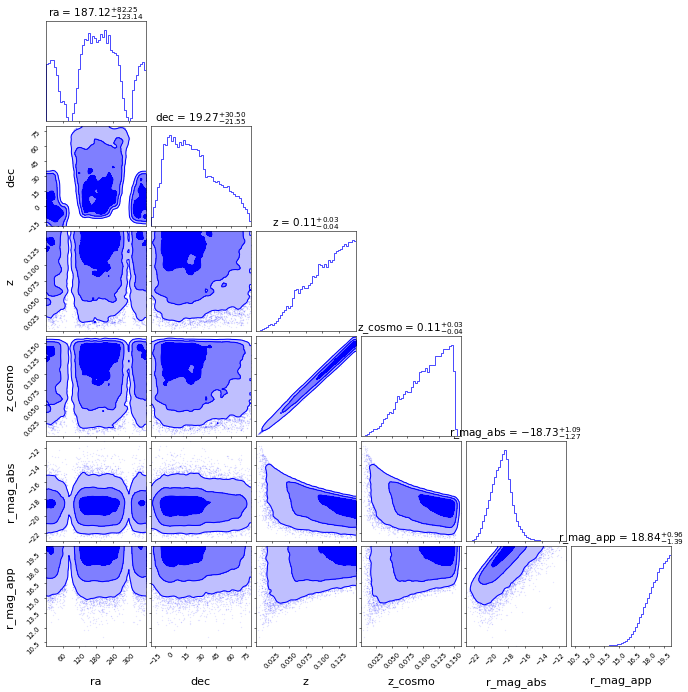

In [22]:
fig = corner_(bgs_df[::50], var_names=['ra','dec','z','z_cosmo','r_mag_abs','r_mag_app'])

In [33]:
from skysurvey.target.snia import SNeIaMagnitude, SNeIaColor, SNeIaStretch
from skysurvey.target import Transient
from skysurvey.effects import dust
import numpy as np

def rand_positions(positions, size=1, weights=None, zcut=0.1):
    positions_ = positions[positions["z"] < zcut] 
    index = np.random.choice(positions_.index, size=size, p=weights)
    
    return (positions_.loc[index].reset_index()['ra'], positions_.loc[index].reset_index()['dec'], positions_.loc[index].reset_index()['z'])


class SNeIa_full_bgs( Transient ):

    _KIND = "SNIa"
    _TEMPLATE = "salt2"
    _RATE = 2.35 * 10**4 # Perley 2020

    # {'model': func, 'prop': dict, 'input':, 'as':}
    _MODEL = dict( redshift = {"kwargs": {"zmax":0.2}},
                   
                   x1 = {"func": SNeIaStretch.nicolas2021}, 
                   
                   c = {"func": SNeIaColor.intrinsic_and_dust},

                   t0 = {"func": np.random.uniform, 
                         "kwargs": {"low":58179, "high":59215} },
                       
                   magabs = {"func": SNeIaMagnitude.tripp1998,
                             "kwargs": {"x1": "@x1", "c": "@c",
                                        "mabs":-19.3, "sigmaint":0.10}
                            },
                           
                   magobs = {"func": "magabs_to_magobs", # defined in Target (mother of Transients)
                             "kwargs": {"z":"@z", "magabs":"@magabs"},
                            },

                   x0 = {"func": "magobs_to_amplitude", # defined in Transients
                         "kwargs": {"magobs":"@magobs", "param_name": "x0"},
                        }, #because it needs to call sncosmo_model.get(param_name)
                       
                   radecz = {"func": rand_positions,
                            "kwargs": {'positions':load_bgs(), 'zcut':0.06}, 
                            "as": ["ra","dec","z"]
                           },
                        
                   mwebv = {"func": dust.get_mwebv, "kwargs":{"ra":"@ra", "dec":"@dec"}}
                    
                    )


Found file ../../project/Projet-LPNHE/data/Uchuu.csv with columns Index(['r_mag_app', 'r_mag_abs', 'dec', 'ra', 'z_cosmo', 'z', 'v_peak',
       'v_rms', 'in_desi'],
      dtype='object')


In [39]:
survey = extract_ztf()
survey.date_range

(58288.17, 59211.227)

In [43]:
snia = SNeIa()
# data = snia.draw(size=5000, inplace=True,  zmax=0.15)
data = snia.draw(tstart=survey.date_range[0], tstop=survey.date_range[1], zmax=0.06, inplace=True)

z=0.06, z=0.1

<Axes: ylabel='Frequency'>

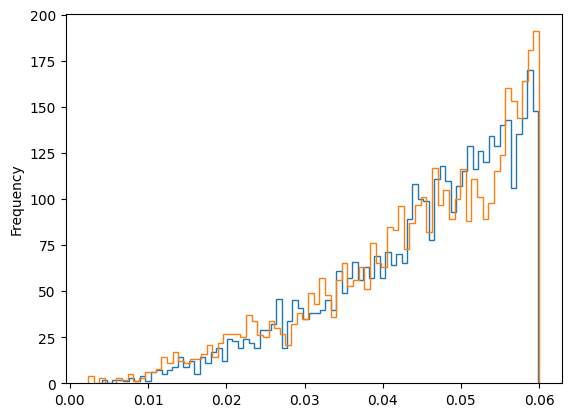

In [45]:
%matplotlib inline
snia.data['redshift'].plot.hist(bins=80, histtype='step')
snia.data['z'].plot.hist(bins=80, histtype='step')

In [46]:
snia.data

redshift     x1      c  ...     magobs        x0  template
0      0.05375 -0.015 -0.154  ...  17.155624  0.002180     salt2
1      0.05645 -2.600  0.008  ...  16.479382  0.004063     salt2
2      0.03095 -1.145 -0.075  ...  17.475552  0.001623     salt2
3      0.04425  1.165  0.349  ...  18.662092  0.000544     salt2
4      0.05875  0.630 -0.067  ...  17.260916  0.001978     salt2
...        ...    ...    ...  ...        ...       ...       ...
4473   0.05245  0.175  0.074  ...  18.297472  0.000761     salt2
4474   0.04515 -0.055  0.088  ...  18.123713  0.000894     salt2
4475   0.02895  0.725  0.053  ...  17.792439  0.001212     salt2
4476   0.05115 -1.790  0.017  ...  15.625290  0.008923     salt2
4477   0.04775  0.360  0.106  ...  17.960896  0.001038     salt2

[4478 rows x 12 columns]

In [93]:
start = time.time()
dset = skysurvey.DataSet.from_targets_and_survey(snia, survey)
stop = time.time()
time.strftime('%H:%M:%S', time.gmtime(stop - start))

/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ztffields/projection.py:157: UserWarning: cannot use dask_geopandas with MultiIndex fields dataframe
  warnings.warn("cannot use dask_geopandas with MultiIndex fields dataframe")

100%|██████████| 8609/8609 [00:46<00:00, 183.83it/s]
/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/skysurvey/dataset.py:154: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences
  data = pandas.concat(lightcurves, keys=fieldids # store fieldid


'00:02:34'

In [94]:
det = dset.get_ndetection(detlimit=7) > 10
detected = det[det].index
len(detected)

2301

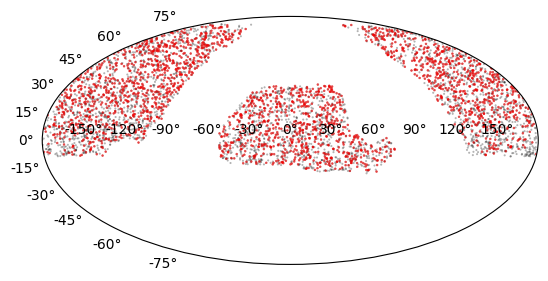

In [95]:
fig = plt.figure()
ax = fig.add_subplot(projection="mollweide")
mollweide_scatter(dset.targets.data, ax=ax,)
mollweide_scatter(dset.targets.data.loc[detected], ax=ax, color='r', marker='*', alpha=0.5)
# plt.savefig('../figures/Uchuu_scatter.png')


In [96]:
from tqdm.notebook import tqdm
n_det = []
dset.data["detected"] = (dset.data["flux"]/dset.data["fluxerr"]) > 5
for i in tqdm(detected):
    target = dset.targets.data.loc[i]
    obs_data = dset.data[dset.data["detected"]].loc[i]
    n_det.append((np.sum(obs_data["time"].between(target["t0"] - 50, target["t0"])), np.sum(obs_data["time"].between(target["t0"], target["t0"]+200))))

  0%|          | 0/2301 [00:00<?, ?it/s]

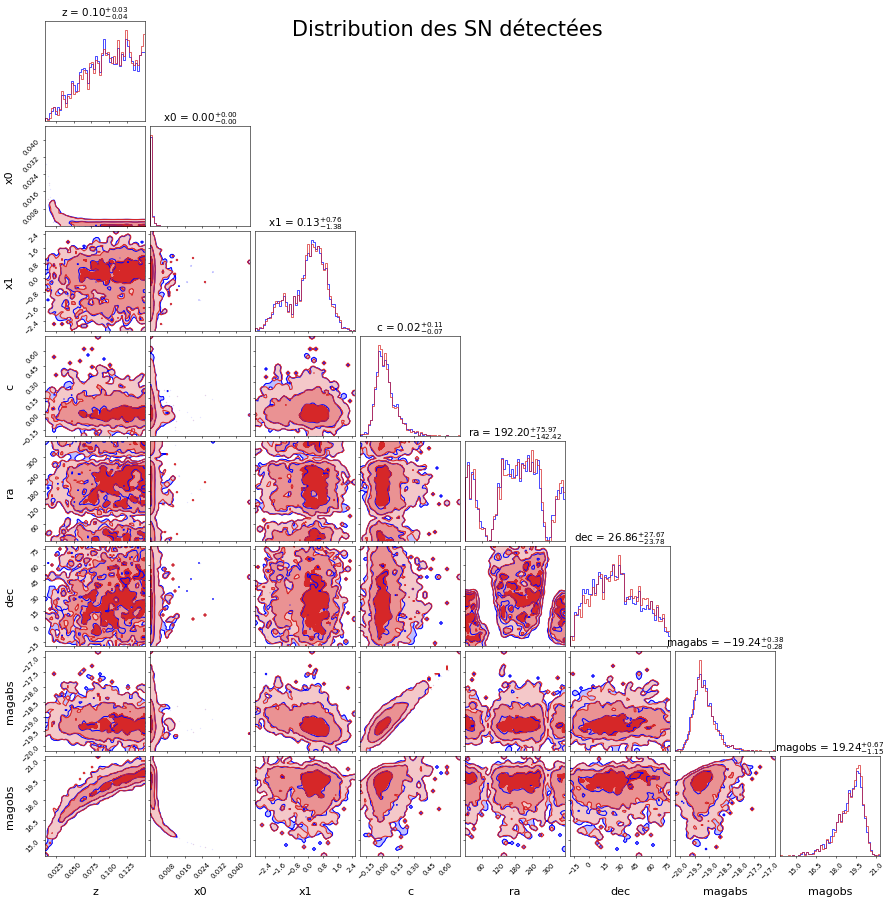

In [97]:
%matplotlib inline
fig = corner_(dset.targets.data.loc[detected],
    var_names=["z", "x0", "x1", "c", "ra", "dec", "magabs", "magobs"],
    labels=[
        r"$z$",
        r"$x_0$",
        r"$x_1$",
        r"$c$",
        r"RA",
        r"DEC",
        r"$M_{ABS}$",
        r"$M_{OBS}$",
    ], title='Distribution des SN détectées')
_=corner_(dset.targets.data.loc[detected[np.all(np.array(n_det) >5, axis=1)]],
    var_names=["z", "x0", "x1", "c", "ra", "dec", "magabs", "magobs"],
    fig = fig,
    color='tab:red')


In [98]:
len(detected[~np.any(np.array(n_det, dtype=tuple) < 3, axis=1)])/len(detected)

0.8370273794002607

In [134]:
id_det=detected[~np.any(np.array(n_det) < 3, axis=1)][:1000]

In [135]:
id_det, detected

(Index([   1,    5,    9,   14,   18,   19,   28,   31,   33,   37,
        ...
        2658, 2659, 2662, 2663, 2666, 2669, 2672, 2674, 2678, 2679],
       dtype='int64', name='index', length=1000),
 Index([   1,    5,    9,   12,   14,   15,   18,   19,   28,   29,
        ...
        4973, 4976, 4978, 4981, 4984, 4988, 4994, 4996, 4997, 4999],
       dtype='int64', name='index', length=2301))

ATTENTION 

In [136]:
fixed = {"z": dset.targets.data.loc[detected]["z"]}

guess = {
    "t0": dset.targets.data.loc[detected]["t0"],
    "c": dset.targets.data.loc[detected]["c"],
    "x0": dset.targets.data.loc[detected]["x0"],
    "x1": dset.targets.data.loc[detected]["x1"],
}
bounds = {
    "t0": dset.targets.data.loc[detected]["t0"].apply(lambda x: [x-5, x+5]),
    "c": dset.targets.data.loc[detected]["c"].apply(lambda x: [-0.3, 1.0]),
    "x0": dset.targets.data.loc[detected]["x0"].apply(lambda x: [0, 0.1]),
    "x1": dset.targets.data.loc[detected]["x1"].apply(lambda x: [-4, 4]),
}

results, meta = dset.fit_lightcurves(
    source=sncosmo.Model("salt2"),
    index=id_det,
    use_dask=False,
    fixedparams=fixed,
    guessparams=guess,
    bounds=bounds,
)

100%|██████████| 1000/1000 [12:33<00:00,  1.33it/s]
/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/skysurvey/dataset.py:513: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pandas.concat(results, keys=index)


In [104]:
nopes = np.where(np.any(np.array(n_det, dtype=tuple) == 0, axis=1))[0]

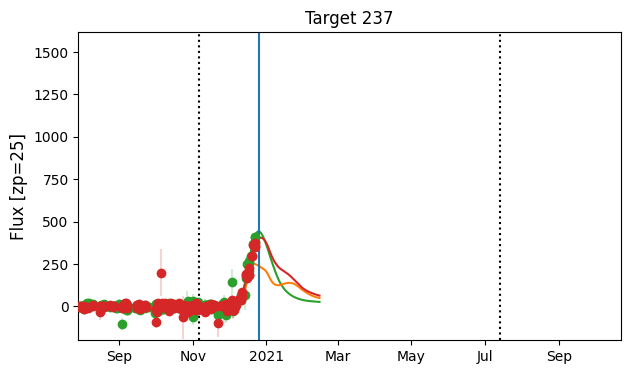

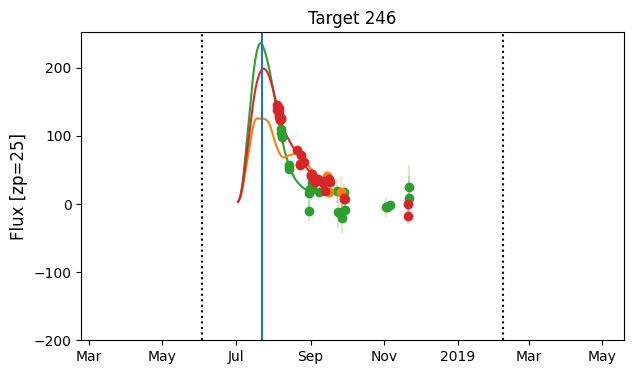

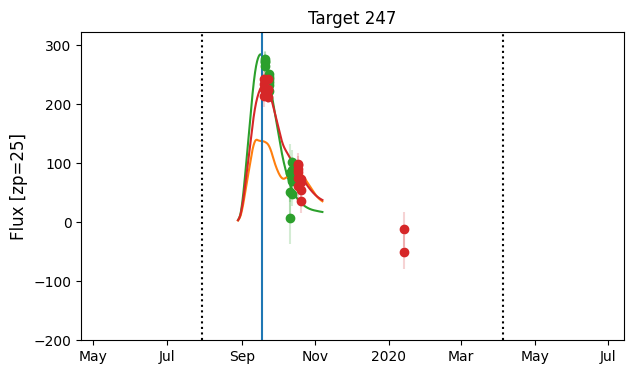

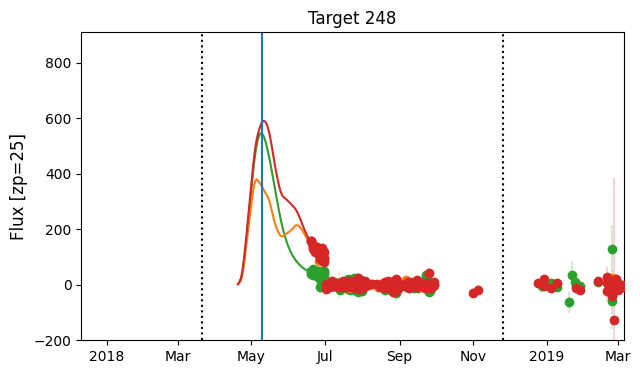

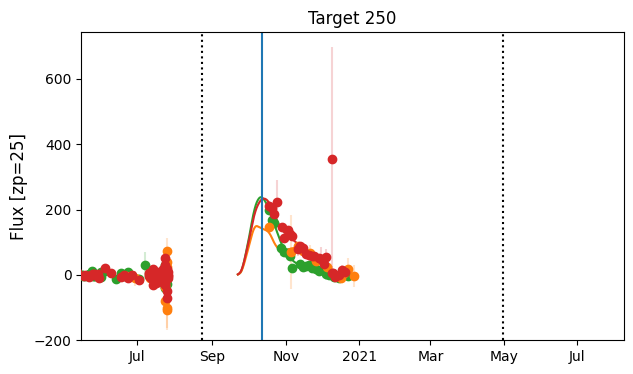

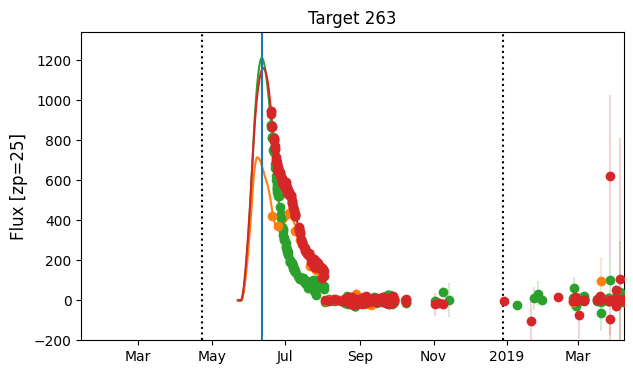

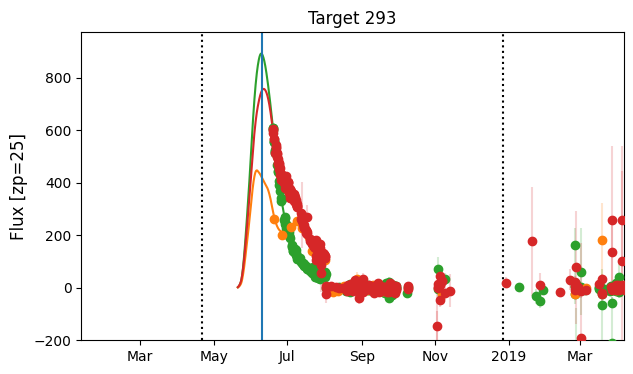

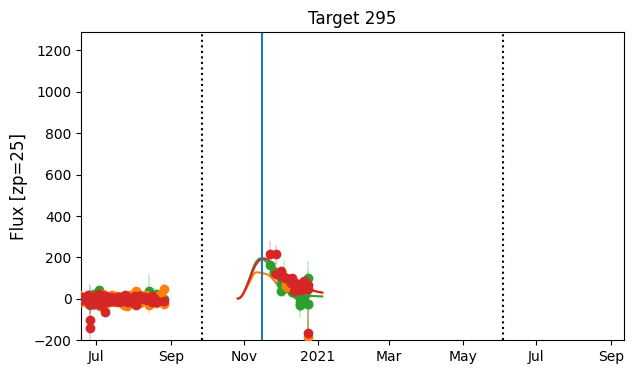

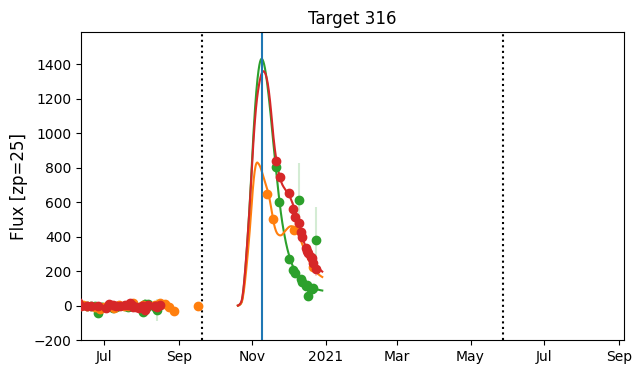

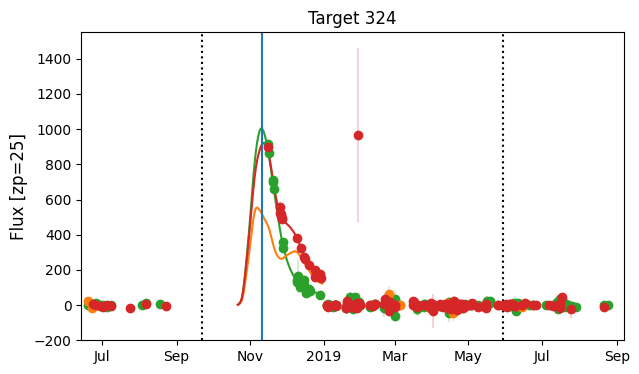

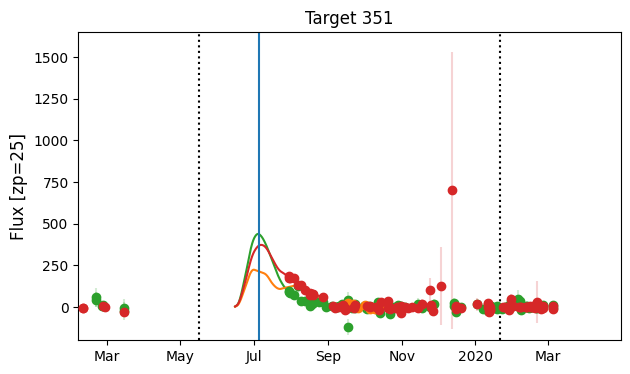

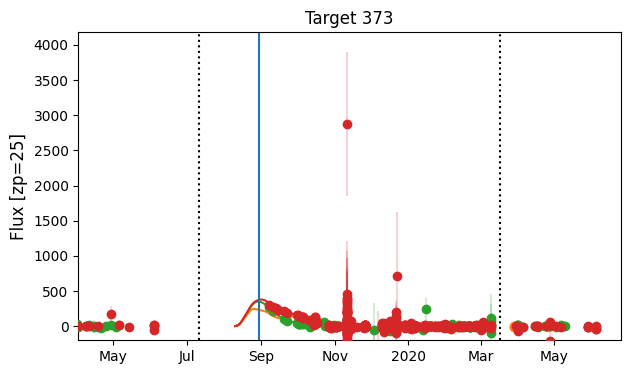

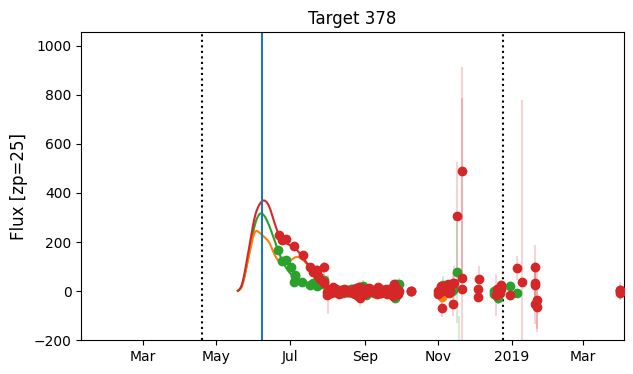

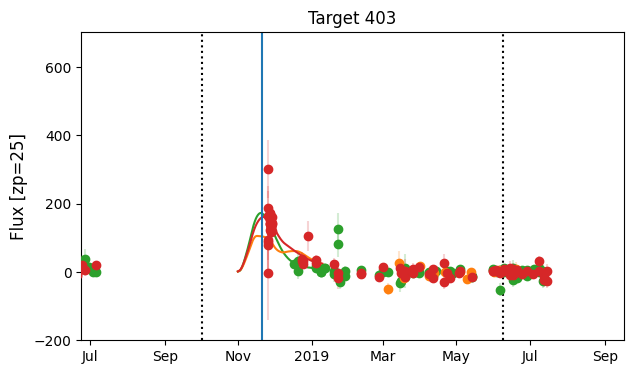

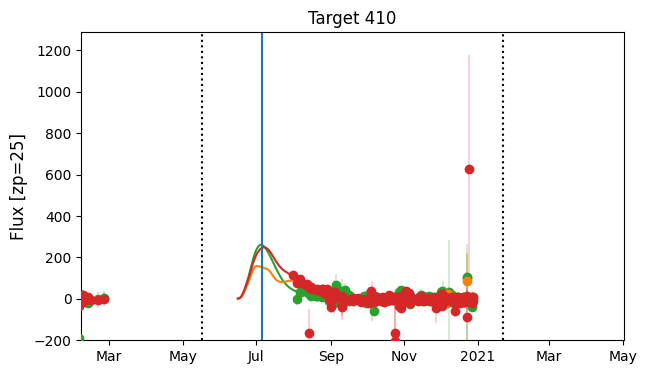

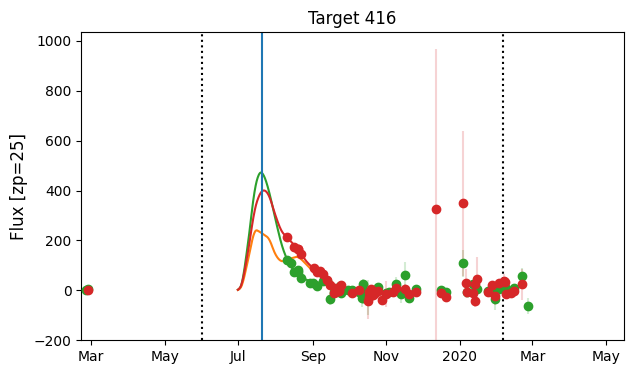

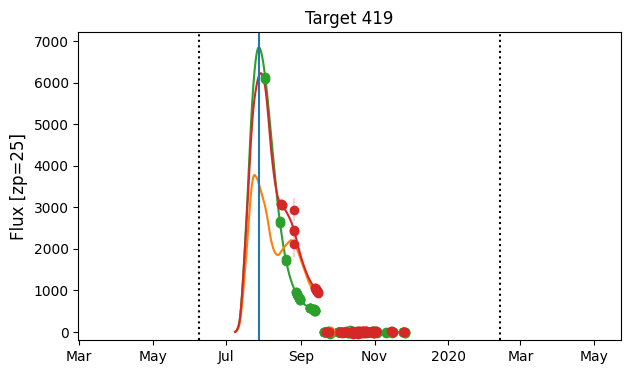

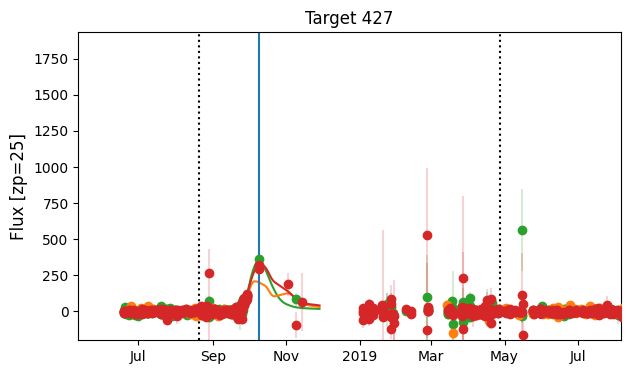

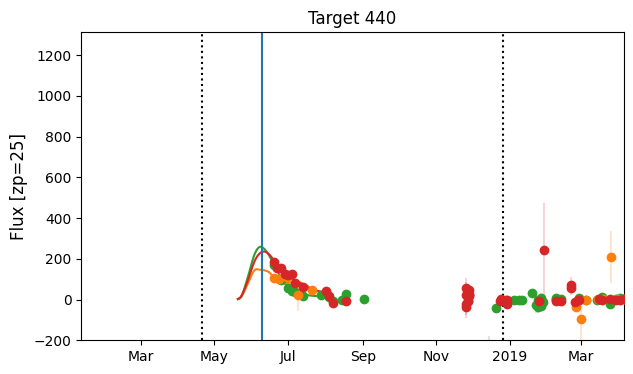

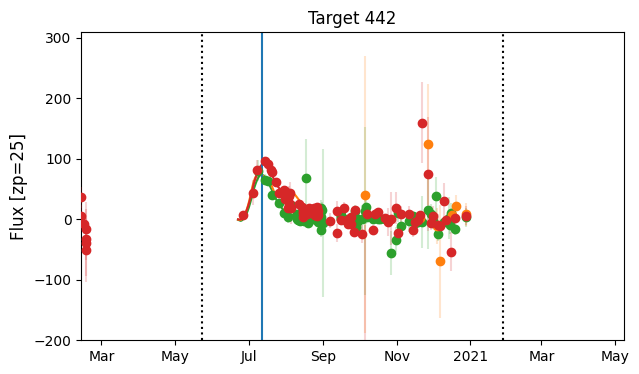

In [338]:
from astropy.time import Time

for i in nopes[20:40]:
    _ = dset.show_target_lightcurve(index=detected[i])
    plt.ylim(-200)
    target = dset.targets.data.loc[detected[i]]
    plt.axvline(Time(target["t0"], format="mjd").datetime)

    plt.axvline(Time(target["t0"]-50, format="mjd").datetime, linestyle='dotted', c='k')
    plt.axvline(Time(target["t0"]+200, format="mjd").datetime, linestyle='dotted', c='k')
    
    plt.xlim(Time(target["t0"]-150, format="mjd").datetime, Time(target["t0"] +300, format="mjd").datetime)
    plt.title(f"Target {i}")


In [137]:

better_results = pandas.DataFrame(
    {
        **{col: np.array(results["value"].loc[map(lambda x: (x, col), id_det)] - \
                      results["truth"].loc[map(lambda x: (x, col), id_det)])
        for col in guess.keys()},
        **{"err_"+col: np.array(results["error"].loc[map(lambda x: (x, col), id_det)]) for col in guess.keys()}
    }
)
better_results

t0         c        x0  ...     err_c    err_x0    err_x1
0   -0.090941 -0.007619  0.000001  ...  0.023199  0.000005  0.113280
1    0.378502 -0.023065 -0.000003  ...  0.024781  0.000005  0.310809
2    0.326101  0.026807 -0.000028  ...  0.018056  0.000013  0.157838
3   -0.013369  0.010412 -0.000002  ...  0.027897  0.000006  0.279750
4    0.469013 -0.008357 -0.000001  ...  0.033507  0.000006  0.416723
..        ...       ...       ...  ...       ...       ...       ...
995  3.138651  0.006942 -0.000008  ...  0.028356  0.000004  0.071524
996  -0.43855  0.014571 -0.000006  ...  0.022108  0.000005  0.266983
997    0.1518  0.002594  0.000008  ...  0.015220  0.000008  0.225164
998  0.238902  0.008003 -0.000001  ...  0.053669  0.000008  0.422540
999 -0.048075  0.017795 -0.000012  ...  0.007055  0.000007  0.055428

[1000 rows x 8 columns]

In [138]:
np.sum(~np.any(np.array(n_det[:400]) < 3, axis=1))

318

Text(0.5, 0.98, 'Erreur absolue sur les paramètres reconstruits')

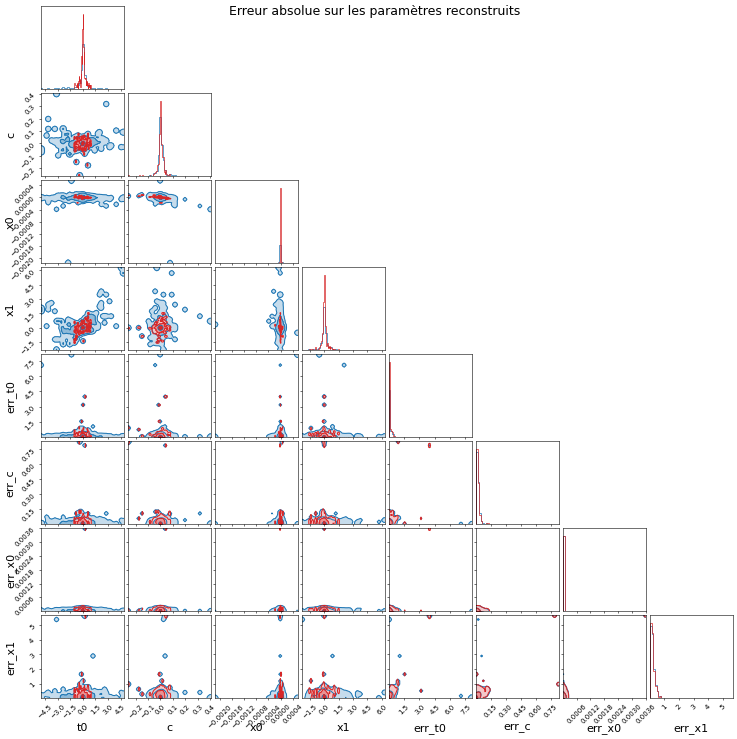

In [123]:
fig = plt.figure(figsize=(15,15),dpi=60)
corner_(better_results,
    fig=fig,
    var_names=list(guess.keys()) + list(map(lambda x : "err_"+x, guess.keys())),
    labels=list(map(lambda x : r"$\Delta "+x+r"$", guess.keys())) + list(map(lambda x : "err_"+x, guess.keys())),
    color='tab:blue',
    show_titles=False)
corner_(better_results[better_results["t0"].between(-1,1)],
    fig=fig,
    var_names=list(guess.keys()) + list(map(lambda x : "err_"+x, guess.keys())),
    color='tab:red',
    show_titles=False)
fig.suptitle('Erreur absolue sur les paramètres reconstruits', fontsize=18)
# plt.savefig('../figures/Uchuu_reconstructed_cuts')

In [143]:
from corner import quantile

filt= (better_results['err_t0'] < quantile(better_results["err_t0"].dropna(), q=0.98)[0]) \
    & (better_results['err_c'] < quantile(better_results["err_c"].dropna(), q=0.98)[0]) \
    & (better_results['err_x0'] < quantile(better_results["err_x0"].dropna(), q=0.98)[0]) \
    & (better_results['err_x1'] < quantile(better_results["err_x1"].dropna(), q=0.98)[0])
#    & np.all(np.array(n_det[:400]) >= 5, axis=1)
sum(filt)

956

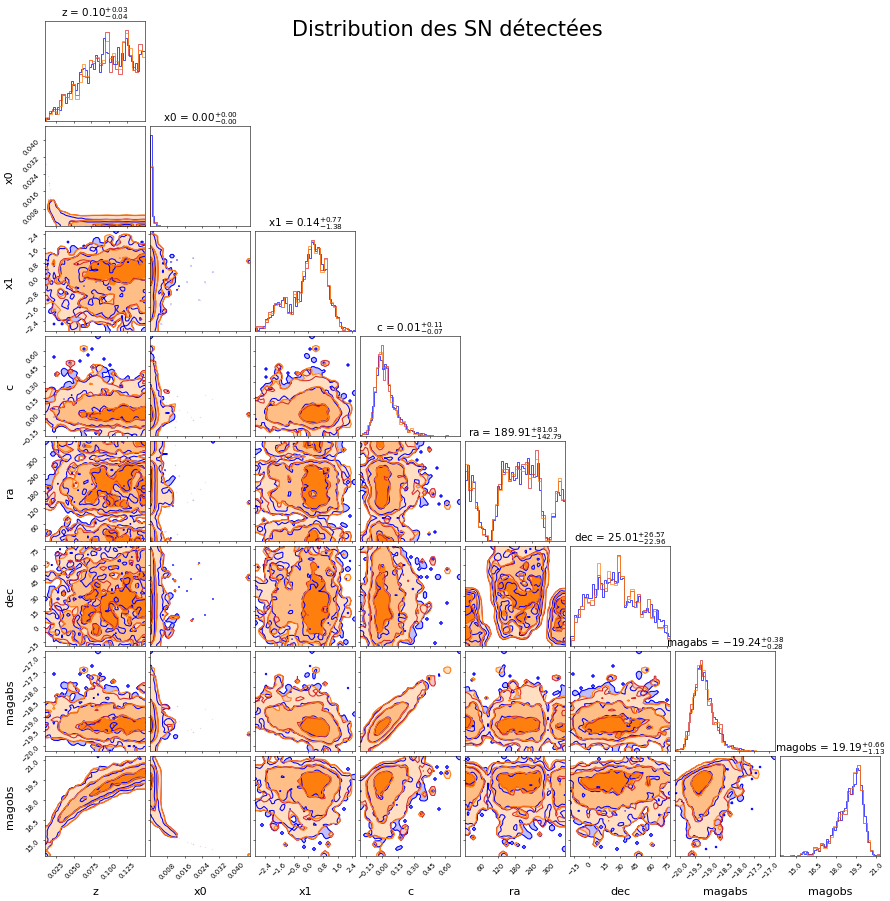

In [145]:
fig = corner_(dset.targets.data.loc[detected],
    var_names=["z", "x0", "x1", "c", "ra", "dec", "magabs", "magobs"],
    labels=[
        r"$z$",
        r"$x_0$",
        r"$x_1$",
        r"$c$",
        r"RA",
        r"DEC",
        r"$M_{ABS}$",
        r"$M_{OBS}$",
    ], title='Distribution des SN détectées')

_ = corner_(dset.targets.data.loc[id_det[better_results["t0"].between(-1,1)]],
    var_names=["z", "x0", "x1", "c", "ra", "dec", "magabs", "magobs"],
    fig=fig,
    color='tab:red',
    bins=30)

_ = corner_(dset.targets.data.loc[id_det[filt]],
    var_names=["z", "x0", "x1", "c", "ra", "dec", "magabs", "magobs"],
    fig=fig,
    color='tab:orange',
    bins=30)

<Axes: ylabel='Frequency'>

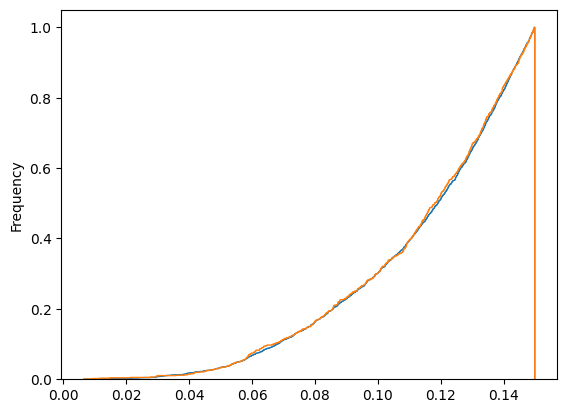

In [152]:
snia.data['redshift'].loc[detected].plot.hist(bins=1000, histtype='step', density=True, cumulative=True)
snia.data['redshift'].loc[id_det[filt]].plot.hist(bins=1000, histtype='step', density=True, cumulative=True)

In [141]:
from corner import quantile
kept = better_results[filt].copy()

print(np.diff(quantile(better_results["err_t0"].dropna(), q=[0.16,0.84]))/np.diff(quantile(kept["err_t0"].dropna(), q=[0.16,0.84])))
print(np.diff(quantile(better_results["err_x0"].dropna(), q=[0.16,0.84]))/np.diff(quantile(kept["err_x0"].dropna(), q=[0.16,0.84])))
print(np.diff(quantile(better_results["err_x1"].dropna(), q=[0.16,0.84]))/np.diff(quantile(kept["err_x1"].dropna(), q=[0.16,0.84])))
print(np.diff(quantile(better_results["err_c"].dropna(), q=[0.16,0.84]))/np.diff(quantile(kept["err_c"].dropna(), q=[0.16,0.84])))


[1.12428655]
[1.06998897]
[1.07055806]
[1.09203852]


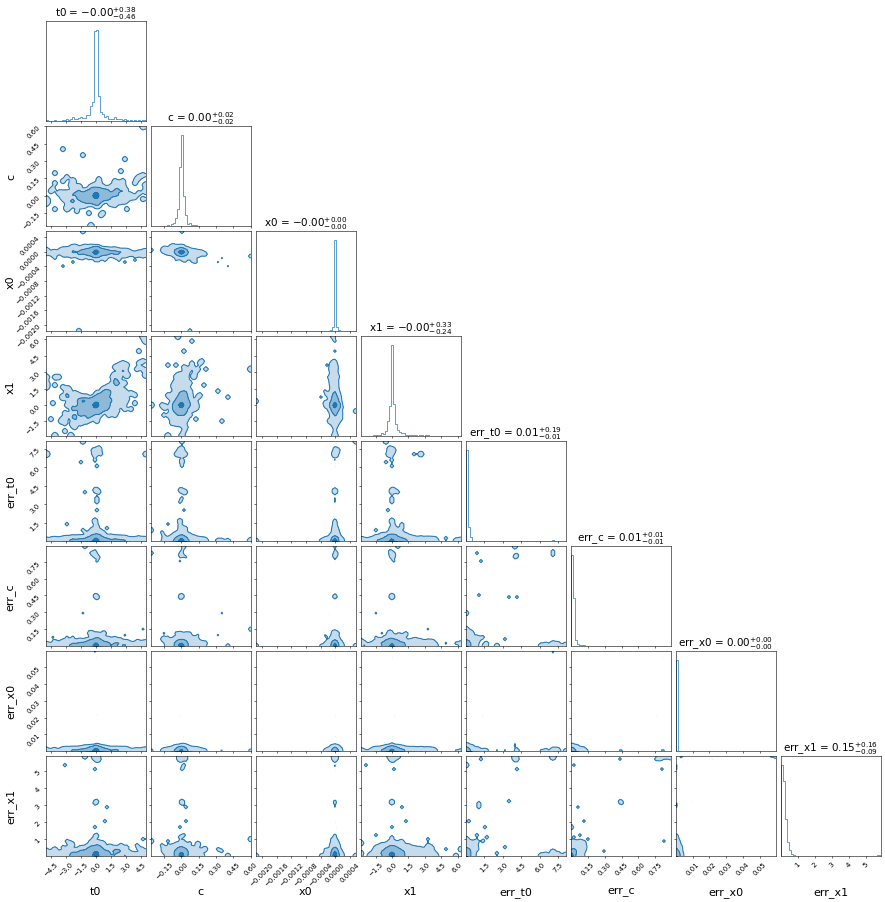

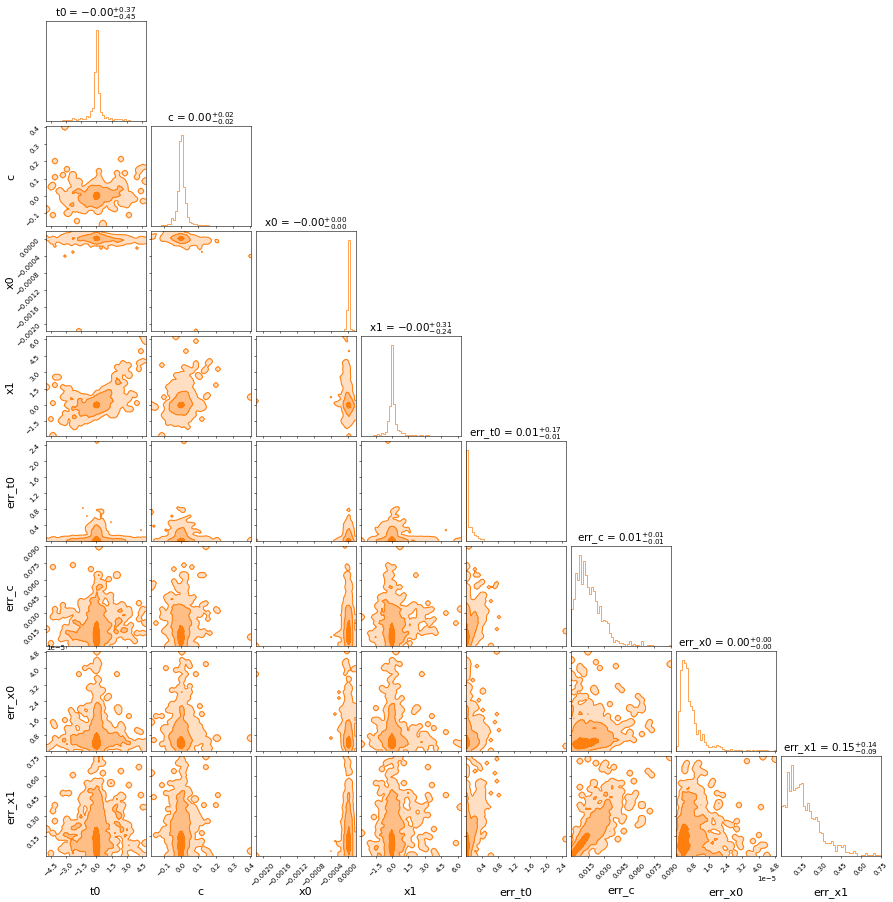

In [142]:
fig=corner_(better_results,
    var_names=list(guess.keys()) + list(map(lambda x : "err_"+x, guess.keys())),
    color='tab:blue')

_=corner_(kept,
    var_names=list(guess.keys()) + list(map(lambda x : "err_"+x, guess.keys())),
    color='tab:orange')
# plt.savefig('../figures/Uchuu_cut')

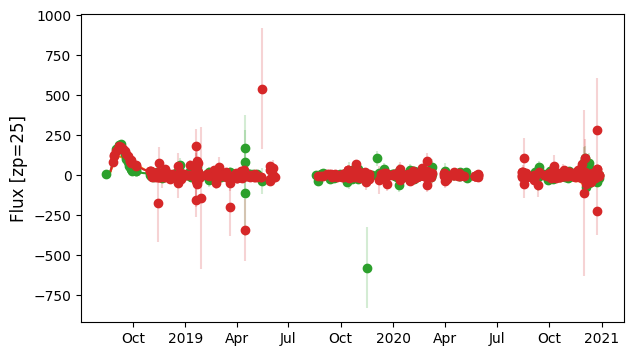

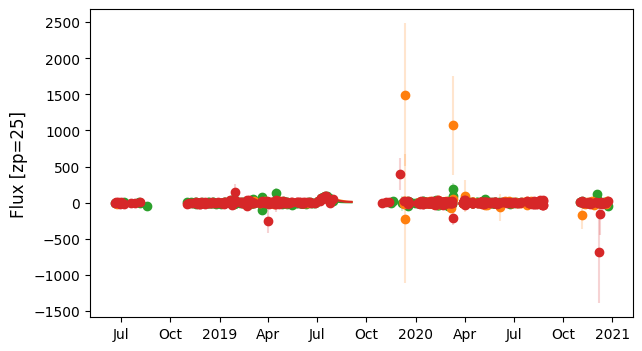

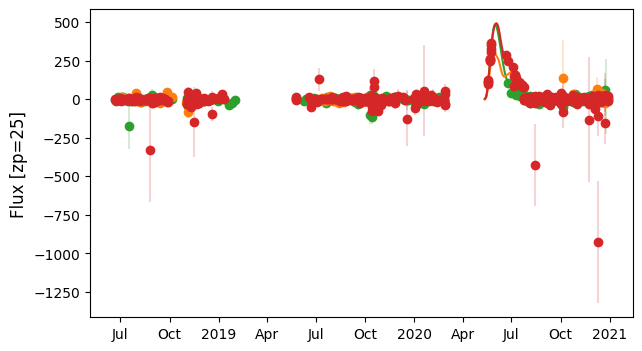

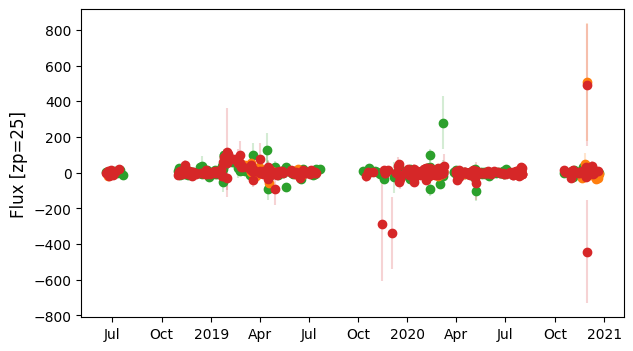

In [105]:
_ = dset.show_target_lightcurve(index=detected[kept[kept["err_t0"]==kept['err_t0'].max()].index[0]])
_ = dset.show_target_lightcurve(index=detected[kept[kept["err_c"]==kept['err_c'].max()].index[0]])
_ = dset.show_target_lightcurve(index=detected[kept[kept["err_x0"]==kept['err_x0'].max()].index[0]])
_ = dset.show_target_lightcurve(index=detected[kept[kept["err_x1"]==kept['err_x1'].max()].index[0]])

# ZTF position in Uchuu

In [3]:
bgs_df = load_bgs(columns=['RA', 'DEC', 'Z', 'Z_COSMO', 'STATUS', 'V_PEAK', 'V_RMS','R_MAG_ABS','R_MAG_APP'])

Found file ../../project/Projet-LPNHE/data/Uchuu.csv with columns Index(['r_mag_app', 'r_mag_abs', 'dec', 'ra', 'z_cosmo', 'z', 'v_peak',
       'v_rms', 'in_desi'],
      dtype='object')


In [4]:
ztf_sn = pandas.read_csv('data/data_ztf.csv', index_col=0)
ztf_sn

z          ra        dec  ...  valid      host  host_not_valid
0     0.061960  127.448018  33.906536  ...      1  47180340           False
5     0.070227  175.776516  15.567129  ...      1  61606285           False
17    0.026112  154.926636  43.366308  ...      1      6768           False
21    0.062131  106.823644  43.316428  ...      1  59183351           False
31    0.077847  230.519091  30.048732  ...      1  47797029           False
...        ...         ...        ...  ...    ...       ...             ...
3606  0.071356  184.013905  45.343774  ...      1  47843066           False
3624  0.222284  206.344125  39.738056  ...      1        -1            True
3625  0.130567  219.245208  50.622639  ...      1  53094290           False
3626  0.270223  224.032458  46.326417  ...      1        -1            True
3627  0.288853  202.785500  52.615139  ...      1        -1            True

[3170 rows x 16 columns]

In [5]:
%matplotlib inline

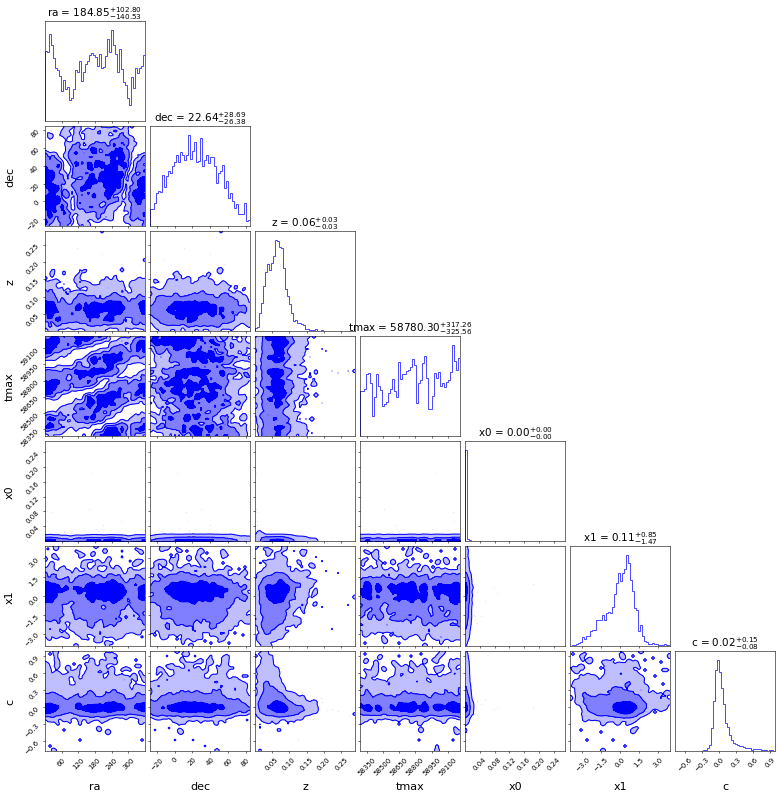

In [6]:
_=corner_(ztf_sn[ztf_sn['valid']==1],
        var_names=['ra','dec','z','tmax', 'x0', 'x1', 'c'])

In [7]:
survey = extract_ztf()

ztf_sn = ztf_sn[ztf_sn['tmax'].between(survey.date_range[0], survey.date_range[1])].copy()
ztf_sn

z          ra        dec  ...  valid      host  host_not_valid
0     0.061960  127.448018  33.906536  ...      1  47180340           False
5     0.070227  175.776516  15.567129  ...      1  61606285           False
17    0.026112  154.926636  43.366308  ...      1      6768           False
21    0.062131  106.823644  43.316428  ...      1  59183351           False
31    0.077847  230.519091  30.048732  ...      1  47797029           False
...        ...         ...        ...  ...    ...       ...             ...
3606  0.071356  184.013905  45.343774  ...      1  47843066           False
3624  0.222284  206.344125  39.738056  ...      1        -1            True
3625  0.130567  219.245208  50.622639  ...      1  53094290           False
3626  0.270223  224.032458  46.326417  ...      1        -1            True
3627  0.288853  202.785500  52.615139  ...      1        -1            True

[3170 rows x 16 columns]

In [18]:
from astropy.coordinates import SkyCoord
from astropy.units import deg,Mpc
from astropy import cosmology

H0 = 67.66  # Hubble rate in km/s/Mpc
Om0 = 0.3111  # Matter density parameter
Ode0 = 1.0 - Om0  # Dark energy density parameter:
cosmo = cosmology.LambdaCDM(H0, Om0, Ode0)

SN_coords = SkyCoord(ra=ztf_sn["ra"]*deg, dec=ztf_sn["dec"]*deg, distance=cosmo.comoving_distance(ztf_sn['z']), unit=(deg,deg,Mpc))


In [14]:
idx=[]

for sn in tqdm(ztf_sn.index):
    ra, dec, z = ztf_sn.loc[sn]['ra'], ztf_sn.loc[sn]['dec'], ztf_sn.loc[sn]['z']
    idx.append(bgs_df[bgs_df['ra'].between(ra - 5, ra + 5) & bgs_df['dec'].between(dec - 5, dec + 5) & bgs_df['z'].between(z - 0.01, z+0.01)].index)

  0%|          | 0/3170 [00:00<?, ?it/s]

In [15]:
np.sum([len(a)==0 for a in idx])

532

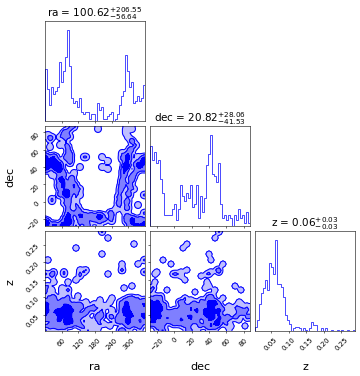

In [16]:
_ = corner_(ztf_sn[[len(a)==0 for a in idx]],
            var_names=['ra','dec','z'])
# plt.savefig('../figures/ZTF_outliers.png')

In [17]:
nearer = []
for i,bgs_ids in tqdm(zip(ztf_sn.index,idx), total=len(idx)):
    if len(bgs_ids):
        nearer.append(bgs_ids[SkyCoord(ra=bgs_df.loc[bgs_ids]['ra'],
                                       dec=bgs_df.loc[bgs_ids]['dec'],
                                       distance=cosmo.comoving_distance(bgs_df.loc[bgs_ids]['z']),
                                       unit=(deg,deg,Mpc)
                                      ).separation_3d(SN_coords[0]).argmin()])
    else:
        nearer.append(-1)

  0%|          | 0/3170 [00:00<?, ?it/s]

In [18]:
ztf_sn['host'] = nearer
ztf_sn['host_not_valid'] = np.array(nearer) < 0
ztf_sn = ztf_sn.astype({"host": int})

In [19]:
ztf_sn[~ztf_sn['host_not_valid']][['ra','dec','z']], bgs_df.loc[ztf_sn[~ztf_sn['host_not_valid']]['host']][['ra','dec','z']]

(              ra        dec         z
 0     127.448018  33.906536  0.061960
 5     175.776516  15.567129  0.070227
 17    154.926636  43.366308  0.026112
 21    106.823644  43.316428  0.062131
 31    230.519091  30.048732  0.077847
 ...          ...        ...       ...
 3583  196.653055  12.460483  0.043230
 3584  147.454117   7.949255  0.068982
 3591   17.004194 -15.405437  0.055010
 3606  184.013905  45.343774  0.071356
 3625  219.245208  50.622639  0.130567
 
 [2638 rows x 3 columns],
                   ra        dec         z
 47180340  127.788197  33.660889  0.062062
 61606285  171.060825  20.484360  0.061759
 6768      150.846416  40.185103  0.035782
 59183351  111.608177  39.410721  0.060429
 47797029  226.026572  34.809858  0.067954
 ...              ...        ...       ...
 4095      192.202384  17.390422  0.035357
 24267101  143.094819  12.765670  0.062655
 37609901   21.405389 -11.148769  0.045069
 47843066  179.064493  45.020359  0.061566
 53094290  214.493904  55.21150

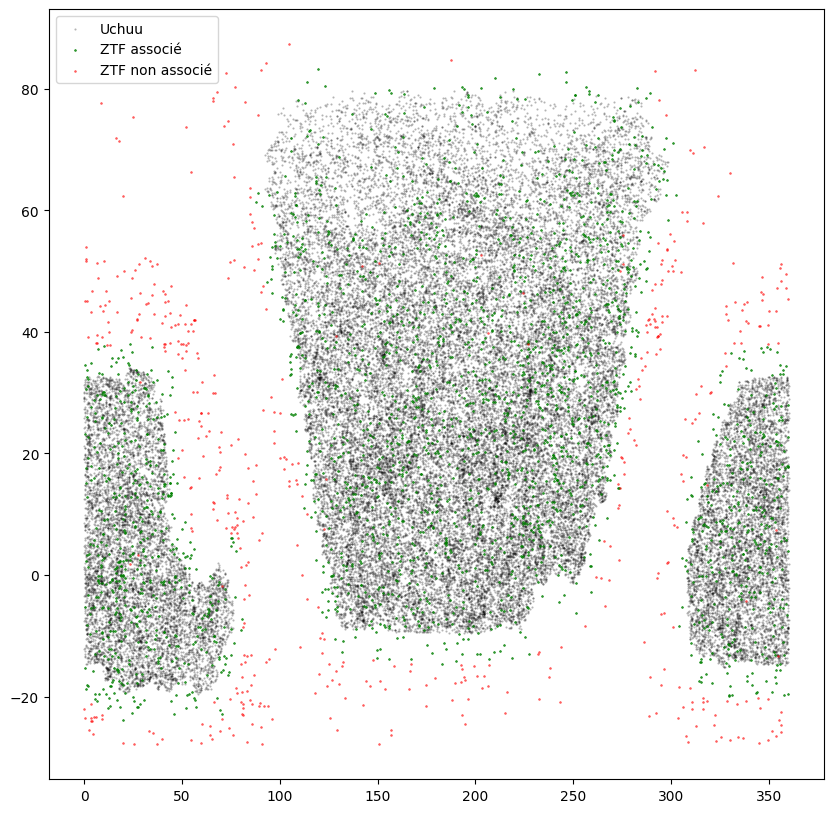

In [20]:
plt.figure(figsize=(10,10))
plt.scatter(np.array(bgs_df[::100]['ra']), np.array(bgs_df[::100]['dec']), alpha=0.3, color="k", s=1, marker=".", label='Uchuu')
plt.scatter(ztf_sn[[len(a)>0 for a in idx]]['ra'], ztf_sn[[len(a)>0 for a in idx]]['dec'], alpha=0.7, color='g', s=1,marker='*', label='ZTF associé')
plt.scatter(ztf_sn[[len(a)==0 for a in idx]]['ra'], ztf_sn[[len(a)==0 for a in idx]]['dec'], alpha=0.5, color='r', s=1,marker='*', label='ZTF non associé')
plt.legend()
# plt.savefig('../figures/ZTF_bgs_outliers.png')

In [32]:
# ztf_sn.to_csv('data/data_ztf.csv')

In [174]:
from skysurvey.target.snia import SNeIaMagnitude, SNeIaColor, SNeIaStretch
from skysurvey.target import Transient
from skysurvey.effects import dust
import numpy as np

def rand_ztf_positions(ztf, positions, size=1, weights=None, zcut=0.1):
    _ztf = ztf.reset_index()[(positions.loc[ztf['host']].reset_index()['z'] < 0.06)].reset_index() 
    index = np.random.choice(_ztf.index, size=size, p=weights)
    
    return (positions.loc[_ztf.loc[index]['host']].reset_index()['ra'],
            positions.loc[_ztf.loc[index]['host']].reset_index()['dec'],
            positions.loc[_ztf.loc[index]['host']].reset_index()['z'],
            _ztf.loc[index]['tmax'])


class SNeIa_ZTF_like( Transient ):

    _KIND = "SNIa"
    _TEMPLATE = "salt2"
    _RATE = 2.35 * 10**4 # Perley 2020

    # {'model': func, 'prop': dict, 'input':, 'as':}
    _MODEL = dict( redshift = {"kwargs": {"zmax":0.2}},
                   
                   x1 = {"func": SNeIaStretch.nicolas2021}, 
                   
                   c = {"func": SNeIaColor.intrinsic_and_dust},
                     
                   magabs = {"func": SNeIaMagnitude.tripp1998,
                             "kwargs": {"x1": "@x1", "c": "@c",
                                        "mabs":-19.3, "sigmaint":0.10}
                            },
                           
                   magobs = {"func": "magabs_to_magobs", # defined in Target (mother of Transients)
                             "kwargs": {"z":"@z", "magabs":"@magabs"},
                            },

                   x0 = {"func": "magobs_to_amplitude", # defined in Transients
                         "kwargs": {"magobs":"@magobs", "param_name": "x0"},
                        }, #because it needs to call sncosmo_model.get(param_name)
                       
                   radecz = {"func": rand_ztf_positions,
                            "kwargs": {'ztf': ztf_sn[~ztf_sn['host_not_valid']], 'positions':bgs_df, 'zcut':0.06}, 
                            "as": ["ra","dec","z","t0"]
                           },
                        
                   mwebv = {"func": dust.get_mwebv, "kwargs":{"ra":"@ra", "dec":"@dec"}}
                    
                    )

In [158]:
snia = SNeIa_ZTF_like()

In [159]:
data = snia.draw(tstart=survey.date_range[0], tstop=survey.date_range[1], zmax=0.06, inplace=True)

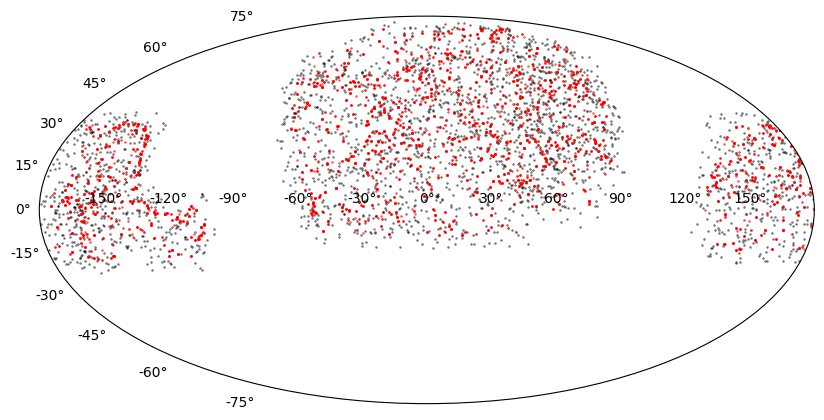

In [161]:
fig = plt.figure(figsize=(10,10))
ax = fig.subplots(subplot_kw=dict(projection='mollweide'))
# ax.scatter(np.array(bgs_df[::100]['ra']), np.array(bgs_df[::100]['dec']), alpha=0.3, color="k", s=1, marker=".", label='Uchuu')
ax.scatter(ztf_sn[~ztf_sn['host_not_valid']]['ra']*np.pi/180 - np.pi, ztf_sn[~ztf_sn['host_not_valid']]['dec']*np.pi/180, alpha=0.4, color='k', s=1,marker='*', label='ZTF')
ax.scatter(data['ra']*np.pi/180 - np.pi, data['dec']*np.pi/180, alpha=0.5, color='r', s=1,marker='*', label='drawn')


In [162]:
start = time.time()
dset = skysurvey.DataSet.from_targets_and_survey(snia, survey)
stop = time.time()
time.strftime('%H:%M:%S', time.gmtime(stop - start))

/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ztffields/projection.py:157: UserWarning: cannot use dask_geopandas with MultiIndex fields dataframe
  warnings.warn("cannot use dask_geopandas with MultiIndex fields dataframe")
100%|██████████| 2410/2410 [00:25<00:00, 93.56it/s] 


'00:00:42'

In [163]:
det = dset.get_ndetection(detlimit=7) > 10
detected = det[det].index
len(detected)

3934

In [164]:
def detection_av_ap(dset, detected):
    n_det = []
    dset.data["detected"] = (dset.data["flux"]/dset.data["fluxerr"]) > 5
    for i in tqdm(detected):
        target = dset.targets.data.loc[i]
        obs_data = dset.data[dset.data["detected"]].loc[i]
        n_det.append((np.sum(obs_data["time"].between(target["t0"] - 50, target["t0"])), np.sum(obs_data["time"].between(target["t0"], target["t0"]+200))))
    return detected[~np.any(np.array(n_det) < 3, axis=1)]
        
id_det = detection_av_ap(dset, detected)

  0%|          | 0/3934 [00:00<?, ?it/s]

In [165]:
def fit_lc(dset, id_det):
    fixed = {"z": dset.targets.data.loc[id_det]["z"]}

    guess = {
        "t0": dset.targets.data.loc[id_det]["t0"],
        "c": dset.targets.data.loc[id_det]["c"],
        "x0": dset.targets.data.loc[id_det]["x0"],
        "x1": dset.targets.data.loc[id_det]["x1"],
    }
    bounds = {
        "t0": dset.targets.data.loc[id_det]["t0"].apply(lambda x: [x-5, x+5]),
        "c": dset.targets.data.loc[id_det]["c"].apply(lambda x: [-0.3, 1.0]),
        "x0": dset.targets.data.loc[id_det]["x0"].apply(lambda x: [-0.1, 0.1]),
        "x1": dset.targets.data.loc[id_det]["x1"].apply(lambda x: [-4, 4]),
    }

    results, meta = dset.fit_lightcurves(
        source=sncosmo.Model("salt2"),
        index=id_det,
        use_dask=False,
        fixedparams=fixed,
        guessparams=guess,
        bounds=bounds,
    )

    better_results = pandas.DataFrame(
        {
            **{col: np.array(results["value"].loc[map(lambda x: (x, col), id_det[:400])] - \
                          results["truth"].loc[map(lambda x: (x, col), id_det[:400])])
            for col in guess.keys()},
            **{"err_"+col: np.array(results["error"].loc[map(lambda x: (x, col), id_det[:400])]) for col in guess.keys()}
        }
    )
    return better_results

In [166]:
results_ztf = fit_lc(dset, id_det[:400])

100%|██████████| 400/400 [03:57<00:00,  1.69it/s]
/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/skysurvey/dataset.py:513: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pandas.concat(results, keys=index)


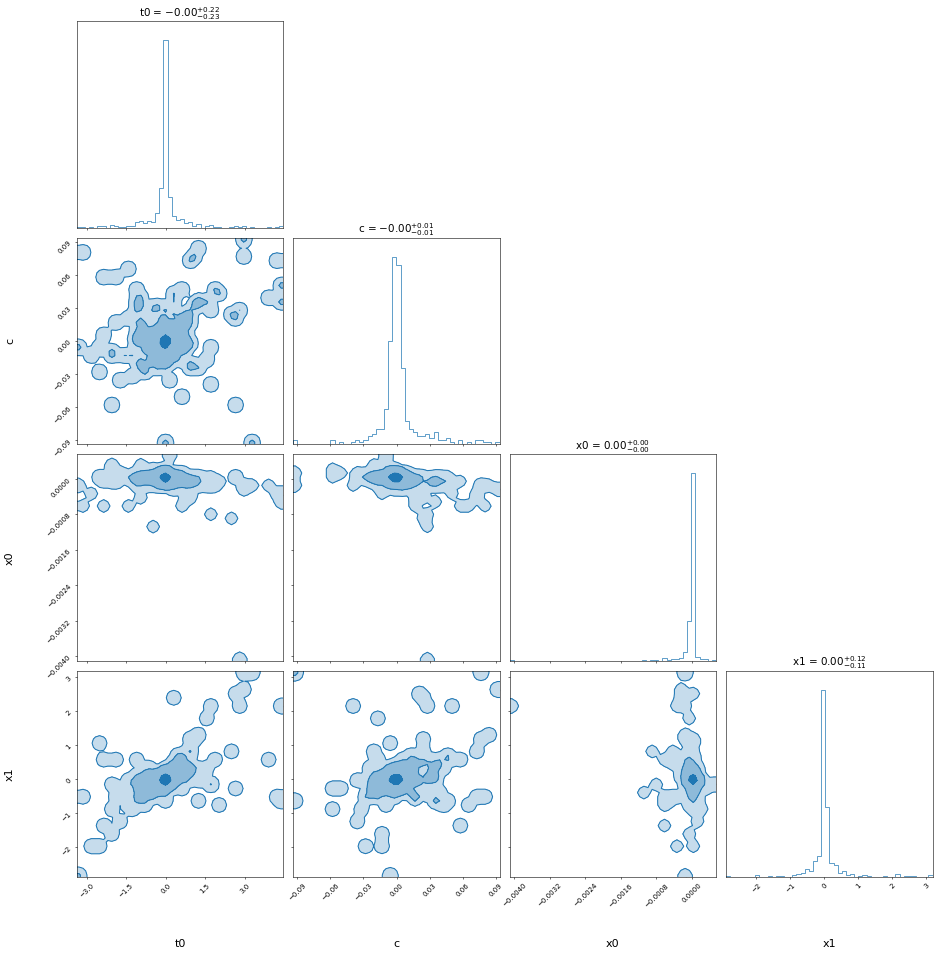

In [167]:
fig=corner_(results_ztf,
    fig=plt.figure(figsize=(20,20)),
    var_names=list(guess.keys()),
    color='tab:blue')

In [46]:
snia_bgs = SNeIa_full_bgs()

In [47]:
snia_bgs.draw(tstart=survey.date_range[0], tstop=survey.date_range[1], zmax=0.06, inplace=True)
dset_bgs = skysurvey.DataSet.from_targets_and_survey(snia_bgs, survey)

/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ztffields/projection.py:157: UserWarning: cannot use dask_geopandas with MultiIndex fields dataframe
  warnings.warn("cannot use dask_geopandas with MultiIndex fields dataframe")
100%|██████████| 7499/7499 [00:31<00:00, 238.29it/s]
/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/skysurvey/dataset.py:154: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences
  data = pandas.concat(lightcurves, keys=fieldids # store fieldid


In [58]:
det = dset_bgs.get_ndetection(detlimit=7) > 10
detected_bgs = det[det].index
id_det_bgs = detection_av_ap(dset_bgs, detected_bgs)

  0%|          | 0/3118 [00:00<?, ?it/s]

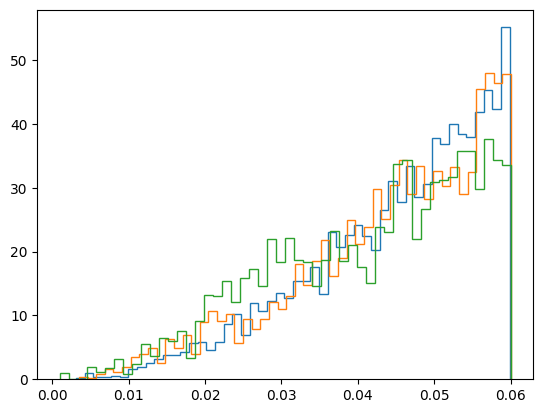

In [168]:
_=plt.hist(snia_bgs.data['redshift'], bins=50, histtype='step', density=True)
_=plt.hist(snia_bgs.data['z'], bins=50, histtype='step', density=True)
_=plt.hist(snia.data['z'], bins=50, histtype='step', density=True)

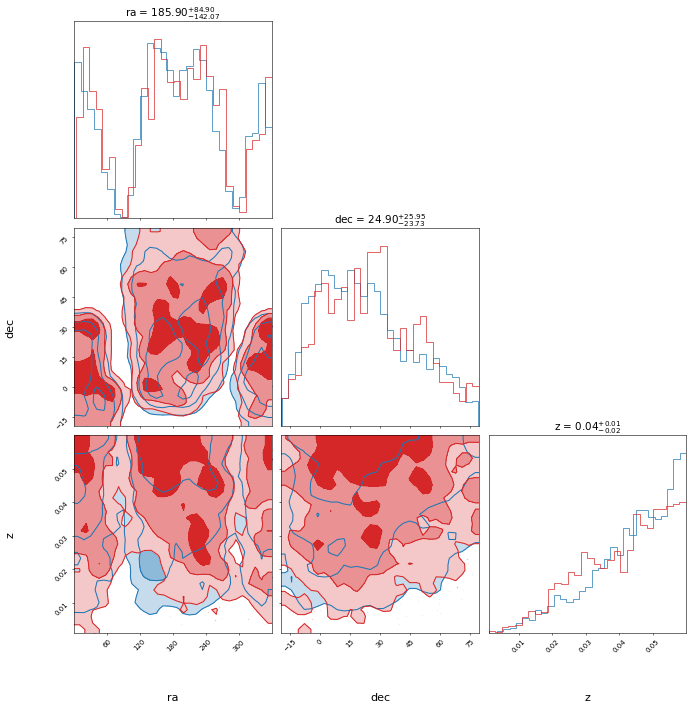

In [169]:
fig =corner_(snia_bgs.data, ['ra','dec','z'], fig=plt.figure(figsize=(15,15)), color='tab:blue', bins=30)
_=corner_(snia.data, ['ra','dec','z'], fig=fig, color='tab:red', bins=30)


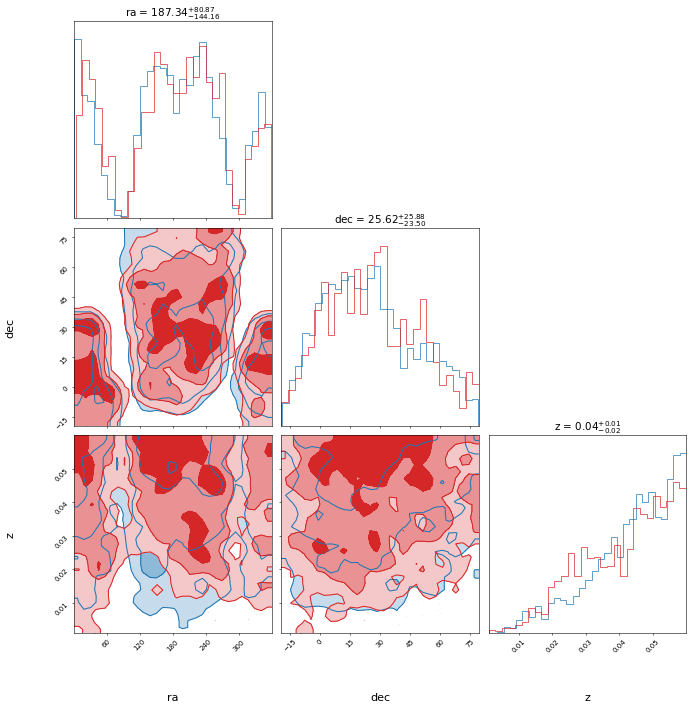

In [170]:
fig =corner_(snia_bgs.data.loc[id_det_bgs], ['ra','dec','z'], fig=plt.figure(figsize=(15,15)), color='tab:blue', bins=30)
_=corner_(snia.data.loc[id_det], ['ra','dec','z'], fig=fig, color='tab:red', bins=30)


In [62]:
results_bgs = fit_lc(dset_bgs, id_det_bgs[:400])

100%|██████████| 400/400 [03:02<00:00,  2.19it/s]


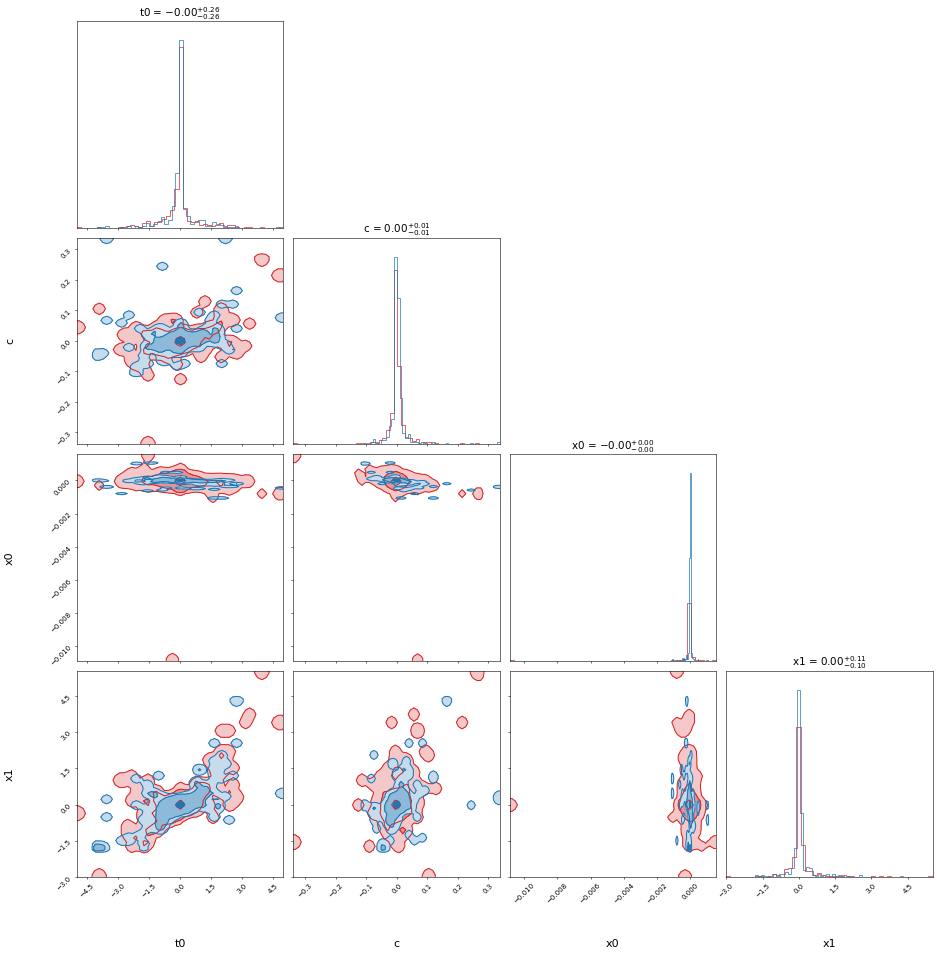

In [171]:
fig=corner_(results_bgs,
    fig=plt.figure(figsize=(20,20)),
    var_names=list(guess.keys()),
    color='tab:red')

_=corner_(better_results,
    fig=fig,
    var_names=list(guess.keys()),
    color='tab:blue')


# MOCKSURVEY

In [3]:
import sncosmo
from mocksurvey.simulations import *


In [4]:
survey = extract_ztf()
snia = SNeIa()
data = snia.draw(size=10000, inplace=True,  zmax=0.15)
dset = skysurvey.DataSet.from_targets_and_survey(snia, survey)

det = dset.get_ndetection(detlimit=7) > 10
detected = det[det].index

/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ztffields/projection.py:157: UserWarning: cannot use dask_geopandas with MultiIndex fields dataframe
  warnings.warn("cannot use dask_geopandas with MultiIndex fields dataframe")
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fd657602050>>
Traceback (most recent call last):
  File "/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 

KeyboardInterrupt



In [ ]:
output = get_detected_sn(dset, detlimit=7, detnumber= 10, per_band=False)
output = get_sn_index(output)
output = get_luminosity_distance(output, snia)
output = get_effective_wavelength(output)
output = eliminate_points_not_in_model(output, snia)
output = get_trueflux_and_amplitude(output, snia)
output = get_snr(output)

In [ ]:
output = discard_small_snr(output, threshold=0)
output = discard_skysurvey_flux(output)

In [ ]:
output['survey'] = 'ztf'

In [20]:
output.to_csv("tests.csv", encoding='utf-8', index=False)

In [5]:
from tqdm.notebook import tqdm

In [6]:
def f(x, a, b, c):
    """
    """
    return a*x**2 + b*x + c


def generate_mock_sample(mock_ztf_path):
    """
    Generates the mock sample based on the generated mock survey.
    
    !! Need to generate the mock sample first
    
    Parameters:
    ------------
    mock_ztf_path : str
        Path to the generated ztf mock sample
    
    Returns:
    ------------
    : pandas.DataFrame
        Mock spectra
    
    """
    d_time = np.array([])
    d_wavelength = np.array([])
    d_flux = np.array([])
    d_fluxerr = np.array([])
    d_valid = np.array([])
    d_spec = np.array([])
    d_exptime = np.array([])
    d_snid = np.array([])
    d_flux_true = np.array([])
    d_x0 = np.array([])
    d_x1 = np.array([])
    d_c = np.array([])
    d_t0 = np.array([])
    d_mwebv = np.array([])
    d_z = np.array([])
    
    mock_survey = pd.read_csv(mock_ztf_path)
    idx = mock_survey['fluxtrue']!=0
    mock_survey = mock_survey[idx]
    
    mock_x0 = mock_survey['x0']
    mock_x1 = mock_survey['x1']
    mock_c = mock_survey['c']
    mock_t0 = mock_survey['t0']
    mock_z = mock_survey['z']
    mock_mwebv = mock_survey['mwebv']
    mock_snid = np.unique(mock_survey['snid'])
    
    
    n = len(mock_snid)
    length_wave = np.array([218, 437, 3258, 656, 868])
    popt = np.array([-7.87649259e-07,  1.08382223e-02, -2.44390307e+01])
    a, b, c = popt
    for i in tqdm(range(n)):
        x0 = np.array(mock_x0[mock_survey['snid']==i])[0]
        x1 = np.array(mock_x1[mock_survey['snid']==i])[0]
        c = np.array(mock_c[mock_survey['snid']==i])[0]
        t0 = np.array(mock_t0[mock_survey['snid']==i])[0]
        z = np.array(mock_z[mock_survey['snid']==i])[0]
        mwebv = np.array(mock_mwebv[mock_survey['snid']==i])[0]
        
        
        wave_size = np.random.choice(length_wave)
        min_wave = np.random.uniform(2900., 3400.)
        max_wave = np.random.uniform(9000., 11000.)
        wavelength = np.linspace(min_wave, max_wave, wave_size)
        mjd = np.random.choice(mock_survey['time'][mock_survey['snid']==i])
        
        source = sncosmo.get_source('salt2', version='2.4')
        dust = sncosmo.CCM89Dust()
        model = sncosmo.Model(source=source, effects=[dust], effect_names=['mw'], effect_frames=['obs'])
        
        p = {'z':z, 't0':t0, 'x0':x0, 'x1': x1, 'c': c, 'ebv':mwebv, 'r_v':3.1}
        model.parameters = list(p.values()) 
        
        
        min_w = model.minwave()
        max_w = model.maxwave()
        
        try:
            flux_true = model.flux(mjd, wavelength)
        except:
            try:
                flux_true = model.flux(mjd, wavelength[wavelength<max_w])
                wavelength = wavelength[wavelength<max_w]
            except:
                flux_true = model.flux(mjd, wavelength[wavelength>min_w])
                wavelength = wavelength[wavelength>min_w]
        #j = np.random.randint(0, N)
        #err_ = spec_data['fluxerr'][j]
        #flx_ = spec_data['flux'][j]
        #norm = flx_/np.max(flux_true)

        #if norm == norm and norm != np.inf and norm != -np.inf:
        #    flux_true *= norm
        #flux_err = err_*np.random.randn(len(flux_true))
        norm_values = np.array([1,1,1,1,1,1,1,1,1,1E+12])
        norm = np.random.choice(norm_values)
        flux_true *= norm
        flux_err = (flux_true/f(wavelength, a, b, c)) *np.random.randn(len(flux_true))
        flux = flux_true + 0.5*flux_err
        
        d_time = np.append(d_time, np.repeat(mjd, len(flux)))
        d_wavelength = np.append(d_wavelength, wavelength)
        d_flux = np.append(d_flux, flux)
        d_fluxerr = np.append(d_fluxerr, np.abs(flux_err))
        d_flux_true = np.append(d_flux_true, flux_true)
        d_valid = np.append(d_valid, np.repeat(1, len(flux)))
        d_exptime = np.append(d_exptime, np.repeat(np.nan, len(flux)))
        d_snid = np.append(d_snid, np.repeat(mock_snid[i], len(flux)))
        d_spec = np.append(d_spec, np.repeat(i, len(flux)))
        d_x0 = np.append(d_x0, np.repeat(x0, len(flux)))
        d_x1 = np.append(d_x1, np.repeat(x1, len(flux)))
        d_c = np.append(d_c, np.repeat(c, len(flux)))
        d_t0 = np.append(d_t0, np.repeat(t0, len(flux)))
        d_z = np.append(d_z, np.repeat(z, len(flux)))
        d_mwebv = np.append(d_mwebv, np.repeat(mwebv, len(flux)))
    data_sim = pd.DataFrame({'spec':d_spec, 'time': d_time, 
                             'wavelength': d_wavelength, 'flux': d_flux, 
                             'fluxerr': d_fluxerr, 'valid': d_valid, 
                             'spec': d_spec, 'exptime': d_exptime, 
                             'snid': d_snid, 'flux_true':d_flux_true,
                             'x0':d_x0, 'x1': d_x1, 'c':d_c, 't0':d_t0,
                             'mwebv':d_mwebv, 'z':d_z})
    return data_sim


In [ ]:
data_mock = generate_mock_sample('tests.csv')
data_mock.to_csv('mock_ztf_spectra.csv')

In [ ]:
%matplotlib inline

In [9]:
data_mock=pandas.read_csv('mock_ztf_spectra.csv')

  0%|          | 0/46 [00:00<?, ?it/s]

Text(0, 0.5, 'flux')

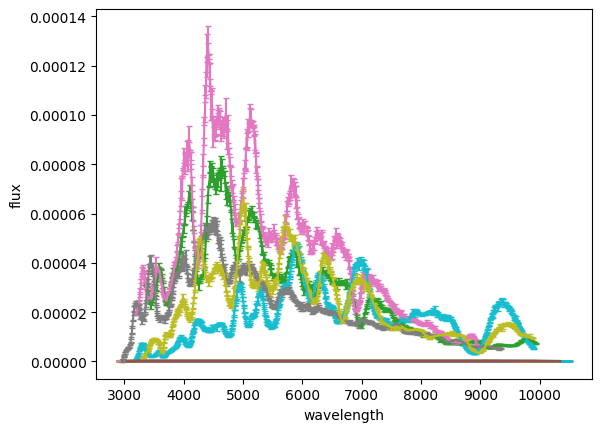

In [13]:
%matplotlib inline

for i in tqdm(data_mock.groupby("spec")["spec"].mean()[::100]):
    plt.errorbar(data_mock[data_mock['spec']==i]["wavelength"], data_mock[data_mock['spec']==i]["flux"], data_mock[data_mock['spec']==i]["fluxerr"], capsize=2)
    
plt.xlabel('wavelength')
plt.ylabel('flux')

In [4]:
# ztf_targets, ztf_survey, ztf_dset, ztf_raw = build_output_to_compress(ztf, 0.0, 0, per_band=False, snr_threshold=0)

INFO:root:Building dataset


Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.


/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/skysurvey/survey/core.py:70: FutureWarning: The provided callable <function min at 0x7fd7b561fb00> is currently using Series.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  return self.data[timekey].agg([np.min, np.max]).values
/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/skysurvey/survey/core.py:70: FutureWarning: The provided callable <function max at 0x7fd7b561f9c0> is currently using Series.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  return self.data[timekey].agg([np.min, np.max]).values


/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ztffields/projection.py:157: UserWarning: cannot use dask_geopandas with MultiIndex fields dataframe
  warnings.warn("cannot use dask_geopandas with MultiIndex fields dataframe")
100%|██████████| 26921/26921 [01:39<00:00, 270.29it/s]  
/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/skysurvey/dataset.py:154: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences
  data = pandas.concat(lightcurves, keys=fieldids # store fieldid
INFO:root:Getting detected SN
INFO:root:Getting SN indexes
INFO:root:Getting luminosity distances in Mpc
INFO:root:Getting effective wavelengths
INFO:root:Eliminating points not in model
INFO:root:Getting true fluxes and amplitudes
INFO:root:Getting snr
INFO:root:Discarding small snr
INFO:root:Getting SN indexes
INFO:root:di